# CARS Reduced Image Segmentation
This notebook will set up and either train a network or predict segmentations based on previous training

## Preliminary steps
Load all the relevant libraries and set up some global parameters

In [1]:
import platform
import sys
import os
import os.path as osp
import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import logging
from logging.handlers import RotatingFileHandler
import traceback

logger = logging.getLogger("Rotating Log")
logger.setLevel(logging.ERROR)
handler = RotatingFileHandler("log.txt", maxBytes=20000, backupCount=5)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

print(platform.python_version())
print(sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from keras import backend as K
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras_radam import RAdam
from keras.layers.advanced_activations import ReLU
from keras_contrib.layers.advanced_activations.swish import Swish
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical, plot_model
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tqdm import tqdm, tqdm_notebook
import talos as ta
from talos.model.early_stopper import early_stopper
#from keras_tqdm import TQDMNotebookCallback

###################################
#Clean session
sess = get_session()
clear_session()
sess.close()
# TensorFlow wizardry
config = tf.ConfigProto(log_device_placement=True)

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

# Magic used by the notebook to show figures inline

%matplotlib inline
# matplotlib default values
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "jet"

# auto-reloading packages
%load_ext autoreload
%autoreload 2

# local package
from mmciad.utils.io import create_samples, load_slides, load_slides_as_dict
from mmciad.utils.generator import DataGenerator
from mmciad.utils.u_net import u_net
from mmciad.utils.u_resnet import u_resnet
from mmciad.utils.custom_loss import (weighted_loss,
                                      jaccard2_loss,
                                      tversky_loss,
                                      categorical_focal_loss,
                                      get_weighted_categorical_crossentropy,
                                      tversky_ce,
                                      jaccard1_coef,
                                      generalised_wasserstein_dice_loss)
from mmciad.utils.preprocessing import calculate_stats, augmentor, calculate_class_weights, class_ratio
from mmciad.utils.callbacks import PatchedModelCheckpoint, DeadReluDetector

3.6.8
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


Using TensorFlow backend.


In [2]:
from skimage.io import imread, imsave
from glob import glob

class_map = {
    "Background": 0,
    "Other": 1,
    "Epithelium": 2,
    "Glandular tissue": 3,
    "Necrosis": 4,
    "Stroma": 5,
    "Muscular tissue": 6,
    "Inflammation_lymphatic tissue": 7,
    "Ulcer": 8,
    "Dysplasia": 9,
    "Keratin pearl": 10,
    "Cancer": 11,
    "IGNORE": 12,
    "Healthy": 13,
}

class_colors = {
    0: [0, 0, 0],
    1: [128, 128, 128],
    2: [75, 195, 0],
    3: [0, 26, 128],
    4: [94, 243, 255],
    5: [255, 179, 128],
    6: [217, 30, 242],
    7: [204, 102, 51],
    8: [153, 51, 0],
    9: [245, 223, 37],
    10: [179, 230, 179],
    11: [255, 0, 0],
    12: [255, 255, 255],
    13: [0, 255, 0],
}
active_labels = [0, 1, 11, 12, 13]
active_classes = [sorted(class_map, key=class_map.get)[i] for i in active_labels]
print(active_classes)
colorvec = np.asarray([class_colors[i] for i in active_labels])
active_colors = {class_: class_colors[class_] for class_ in active_labels}
num_cls = len(active_labels)
print(active_colors)
ignore_cls = 12

path = "./data/"
data_path = "./data/"
train_path = "rtrain/"
val_path = "rval/"
test_path = "rval/"
bg_class = class_map["Background"]
ignore_color = class_colors[12]
np.random.seed(1992)

['Background', 'Other', 'Cancer', 'IGNORE', 'Healthy']
{0: [0, 0, 0], 1: [128, 128, 128], 11: [255, 0, 0], 12: [255, 255, 255], 13: [0, 255, 0]}


In [43]:
#duplicate = [class_colors[label] for label in [2, 3, 6, 9, 11]]
#create_samples(data_path, colorvec[bg_class, :], ignore_color, "train", duplicate)
filter_dict = {
    "IGNORE":     (class_colors[class_map["IGNORE"]]    , 0.9, 0.9, 1.0),
    "Background": (class_colors[class_map["Background"]], 0.9, 0.9, 1.0),
    "Background": (class_colors[class_map["Background"]], 0.5, 0.7, None),
    "Other":      (class_colors[class_map["Other"]],      0.5, 0.8, None)
}
for root, _, files in os.walk(os.path.join(data_path, train_path)):
    for name in files:
        os.unlink(os.path.join(root, name))

for root, _, files in os.walk(os.path.join(data_path, val_path)):
    for name in files:
        os.unlink(os.path.join(root, name))

create_samples(data_path, filter_dict, "train", train_path)
create_samples(data_path, filter_dict, "test", val_path)


## Create a random list of training tiles
#train_list = glob(osp.join(data_path, train_path, "*.tif"))
#np.random.shuffle(train_list)
#VAL_FRACTION = .25
#sample_length = len(train_list)
#val_size = round(sample_length*VAL_FRACTION)
#
#val_from_list = train_list[:val_size]
## Create a mirror list of GT tiles
#val_from_gt_list = [
#    osp.join(data_path, train_path, "gt/", osp.split(i)[1]) for i in val_from_list
#]
## Create list of target paths for each element in val_from_list and val_from_gt_list
#val_to_list = [
#    osp.join(data_path, val_path, osp.split(val_from_list[i])[1]) for i in range(val_size)
#]
#val_to_gt_list = [
#    osp.join(data_path, val_path, "gt/", osp.split(val_from_gt_list[i])[1])
#    for i in range(val_size)
#]
# Copy the chosen tiles from train to val
#os.makedirs(osp.join(data_path, val_path, "gt", ""), exist_ok=True)
#for i in range(val_size):
#    os.rename(val_from_list[i], val_to_list[i])
#    os.rename(val_from_gt_list[i], val_to_gt_list[i])

print(
    """
    Train set:
    ---------
    Created {} X tiles in directory: {}.
    Created {} Y tiles in directory: {}.
    
    Validation set:
    ---------------
    Created {} X tiles in directory: {}.
    Created {} Y tiles in directory: {}.
    
    Test set:
    ---------
    Created {} X tiles in directory {}.
    Created {} Y tiles in directory {}.""".
    format(
        len([name for name in os.listdir(osp.join(data_path, train_path)) if os.path.isfile(osp.join(data_path, train_path, name))]),
        osp.join(data_path, train_path),
        len([name for name in os.listdir(osp.join(data_path, train_path, "gt/")) if os.path.isfile(osp.join(data_path, train_path, "gt/", name))]),
        osp.join(data_path, train_path, "gt/"),
        len([name for name in os.listdir(osp.join(data_path, val_path)) if os.path.isfile(osp.join(data_path, val_path, name))]),
        osp.join(data_path, val_path),
        len([name for name in os.listdir(osp.join(data_path, val_path, "gt/")) if os.path.isfile(osp.join(data_path, val_path, "gt/", name))]),
        osp.join(data_path, val_path, "gt/"),
        len([name for name in os.listdir(osp.join(data_path, test_path)) if os.path.isfile(osp.join(data_path, test_path, name))]),
        osp.join(data_path, test_path),
        len([name for name in os.listdir(osp.join(data_path, test_path, "gt/")) if os.path.isfile(osp.join(data_path, test_path, name))]),
        osp.join(data_path, test_path, "gt/"),
    )
)



    Train set:
    ---------
    Created 3240 X tiles in directory: ./data/rtrain/.
    Created 3240 Y tiles in directory: ./data/rtrain/gt/.
    
    Validation set:
    ---------------
    Created 629 X tiles in directory: ./data/rval/.
    Created 629 Y tiles in directory: ./data/rval/gt/.
    
    Test set:
    ---------
    Created 629 X tiles in directory ./data/rval/.
    Created 629 Y tiles in directory ./data/rval/gt/.


In [3]:
train_m, train_s, x_min, x_max = calculate_stats(path=data_path, local=False)

Text(0.5, 1.0, 'warp+elastic')

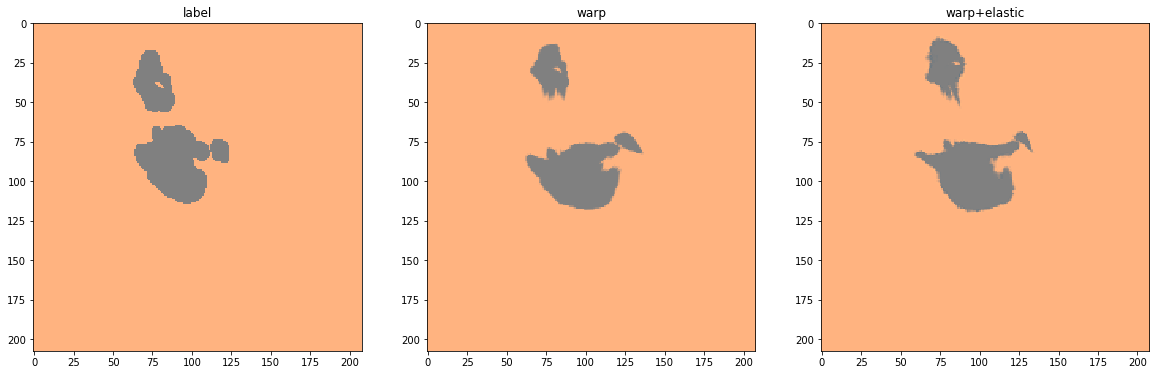

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa
plt.rcParams['figure.figsize'] = (20.0, 16.0)
mytest = imread("./data/train/gt/X_1001.tif")
warp = iaa.PiecewiseAffine(scale=0.05, nb_rows=6, nb_cols=6, mode='reflect')
trans = iaa.ElasticTransformation(alpha=80, sigma=(8.0), mode="reflect")
warp_label = warp.augment_image(mytest)
twarp_label = trans.augment_image(warp_label)
plt.subplot(1, 3, 1)
plt.imshow(mytest)
plt.title("label")
plt.subplot(1, 3, 2)
plt.imshow(warp_label)
plt.title("warp")
plt.subplot(1, 3, 3)
plt.imshow(twarp_label)
plt.title("warp+elastic")

## Data Augmentation for Segmentation
This part will artificially increase the data set to improve the networks ability to generalize.
Currently this is a very rudimentary procedure involving flips and 90 degree rotations. This can be changed in the future (See e.g. [ImgAug](https://github.com/aleju/imgaug)).

## U-net model

In [4]:
# Calculate the class weights for the training data set
# Optionally exclude a label by settings its weight to 0 using the ignore=label option
cls_wgts = calculate_class_weights(data_path, active_labels, class_colors, prefix="rtrain", ignore=ignore_cls)
print("cls_wgts:\n", cls_wgts)
class_ratios = class_ratio(data_path, active_labels, class_colors, prefix="rtrain")
print("class_ratios:\n", class_ratios)


cls_wgts:
 {0: 0.5517774875166446, 1: 0.6636867009103031, 11: 1.1698527040928717, 12: 0, 13: 1.7590549528987345}
class_ratios:
 {0: 0.3624649510441778, 1: 0.3013470056363686, 11: 0.1709616939810249, 12: 0.05152893489982833, 13: 0.11369741443860033}


In [9]:
from functools import partial
from mmciad.utils.custom_loss import w_categorical_crossentropy
cls_wgts = {0: 0.6462842253714038, 1: 4.277279367175925, 2: 0.7650382887989682, 3: 2.3366233721836207,
            5: 0.38495865467512297, 6: 11.749891543465838, 7: 0.7357313031667244,
            9: 3.3815931126719256, 10: 107.61779250337312, 11: 0.5449941506459005, 12: 0}
w_array = np.ones((num_cls,num_cls))
for cls_id, weight in enumerate(cls_wgts.values()):
    w_array[cls_id, :] = weight # populate False negatives
w_array[:, -1] = 100.0 # Increase False Negative penalty for IGNORE class
np.fill_diagonal(w_array, 1) # Populate True positives
w_array[-1, :] = 0.0 # Remove False positives penalty for IGNORE class
#w_array_t = w_array.swapaxes(0, 1)
w_array[2,  7] = 70 # Guessing Epithelium as Dysplasia
w_array[2,  9] = 80 # Guessing Epithelium as Cancer
w_array[9,  2] = 100 # Guessing Cancer as Epithelium
w_array[7,  2] = 90 # Guessing Dysplasia as Epithelium
w_array[4,  6] = 2 # Guessing Stroma as Inflammation
w_array[4,  9] = 40 # Guessing Stroma as Cancer
w_array[6,  4] = 4 # Guessing Inflammation as Stroma
w_array[6,  9] = 30 # Guessing Inflammation as Cancer



r"""
    Example weight matrix

 -> False positives
 v  False negatives
 \ True positives, always 1

                True class
P
r    ___|  A  |  B  |  C  |  D  |  E
e c   A |  1  | 3.0 | 0.5 | 1.7 | 0.3 
d l   B | 0.6 |  1  | 0.5 | 1.7 | 0.3
i a   C | 0.6 | 3.0 |  1  | 1.7 | 0.3
c s   D | 0.6 | 3.0 | 0.5 |  1  | 0.3
t s   E | 0.6 | 3.0 | 0.5 | 1.7 |  1
e
d
"""
with np.printoptions(precision=3, suppress=True, linewidth=100):
    print(w_array)
w_ce = partial(w_categorical_crossentropy, weights=w_array)
w_ce.__name__ = 'weighted_categorical_crossentropy'

[[  1.      0.646   0.646   0.646   0.646   0.646   0.646   0.646   0.646   0.646 100.   ]
 [  4.277   1.      4.277   4.277   4.277   4.277   4.277   4.277   4.277   4.277 100.   ]
 [  0.765   0.765   1.      0.765   0.765   0.765   0.765  70.      0.765  80.    100.   ]
 [  2.337   2.337   2.337   1.      2.337   2.337   2.337   2.337   2.337   2.337 100.   ]
 [  0.385   0.385   0.385   0.385   1.      0.385   2.      0.385   0.385  40.    100.   ]
 [ 11.75   11.75   11.75   11.75   11.75    1.     11.75   11.75   11.75   11.75  100.   ]
 [  0.736   0.736   0.736   0.736   4.      0.736   1.      0.736   0.736  30.    100.   ]
 [  3.382   3.382  90.      3.382   3.382   3.382   3.382   1.      3.382   3.382 100.   ]
 [107.618 107.618 107.618 107.618 107.618 107.618 107.618 107.618   1.    107.618 100.   ]
 [  0.545   0.545 100.      0.545   0.545   0.545   0.545   0.545   0.545   1.    100.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.   ]

In [87]:
from collections import OrderedDict

inv_map = {v: k for k, v in class_map.items()}
rank = {"Healthy": 0, "Neutral": 1, "Inconclusive": 2, "Indicative": 3, "Malignant": 4}
indicator = ["Neutral",
             "Neutral",
             "Healthy",
             "Healthy",
             "Indicative",
             "Healthy",
             "Healthy",
             "Inconclusive",
             "Inconclusive",
             "Indicative",
             "Malignant",
             "Malignant",
             "Neutral",
]
sorted_indicator = {key: val for key, val in enumerate(indicator) if key in class_ratios.keys()}
sorted_indicator = OrderedDict(sorted(sorted_indicator.items(), key=lambda x: (rank[sorted_indicator[x[0]]], -class_ratios[x[0]])))

print(r"\hline"
      + "\n{:<50} & {} & {}".format("{\\bf Label}", "{\\bf Indicator}", "{\\bf Abundance}")
      + r" \\ \thickhline")
for key, val in sorted_indicator.items():
    label_color = (r"\fbox{\mybox}" if key == 12 else 
    r"\lbox{" + ', '.join(str(x).rjust(3, ' ') for x in class_colors[key]) + r"}")
    print(
        f"{label_color:<20} {inv_map[key]:>29} & {val:>15} & {class_ratios[key]*100:>6.2f}"
        + r" \%      \\ \hline"
    )

print(sum([x for x in class_ratios.values()]))

\hline
                                                            {\bf Label} & {\bf Indicator} & {\bf Abundance}\\ \thickhline
\colorbox[RGB]{255, 179, 128}{\parbox[c][1ex]{1ex}{ }}           Stroma &         Healthy &  27.41 \%      \\ \hline
\colorbox[RGB]{ 75, 195,   0}{\parbox[c][1ex]{1ex}{ }}       Epithelium &         Healthy &  12.37 \%      \\ \hline
\colorbox[RGB]{  0,  26, 128}{\parbox[c][1ex]{1ex}{ }} Glandular tissue &         Healthy &   4.31 \%      \\ \hline
\colorbox[RGB]{217,  30, 242}{\parbox[c][1ex]{1ex}{ }}         Muscular &         Healthy &   0.78 \%      \\ \hline
\colorbox[RGB]{  0,   0,   0}{\parbox[c][1ex]{1ex}{ }}       Background &         Neutral &  19.11 \%      \\ \hline
\fbox{\parbox[c][1ex]{1ex}{ }}                                   IGNORE &         Neutral &   7.45 \%      \\ \hline
\colorbox[RGB]{128, 128, 128}{\parbox[c][1ex]{1ex}{ }}            Other &         Neutral &   3.28 \%      \\ \hline
\colorbox[RGB]{204, 102,  51}{\parbox[c][1ex]{1ex}{ 

In [5]:
w_TL = weighted_loss(tversky_loss, cls_wgts)
#w_cat_CE = weighted_loss(categorical_crossentropy, cls_wgts)
#w_cat_CE = get_weighted_categorical_crossentropy(weights=[v for v in cls_wgts.values()])
w_TL.__name__ = "w_TL"
#w_cat_CE.__name__ = "w_cat_CE"

In [8]:
from mmciad.utils.hyper import talos_presets

# I/O Params
weight_path = "./weights/"

IMG_ROWS, IMG_COLS, IMG_CHANNELS = (None, None, 3)
# architecture params
NB_FILTERS_0 = 64
SIGMA_NOISE = 0.01

# ****  deep learning model
SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
BATCH_SIZE = 16
NB_EPOCH = 400
NB_FROZEN = 40
VERBOSE = 0

# ****  train
today_str = str(datetime.date.today())

train_generator = DataGenerator(
    osp.join(data_path, train_path),
    colorvec,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_cls,
    shuffle=True,
    augmenter=True,
)

val_generator = DataGenerator(
    osp.join(data_path, val_path),
    colorvec,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_cls,
    shuffle=True,
    augmenter=True,
)

statics = {
    "shape": SHAPE,
    "nb_epoch": NB_EPOCH,
    "nb_frozen": NB_FROZEN,
    "nb_filters_0": NB_FILTERS_0,
    "batch_size": BATCH_SIZE,
    "verbose": VERBOSE,
    "num_cls": num_cls,
    "batchnorm": True,
    "maxpool": False,
    "today_str": today_str,
    "opt": Adam,
    "depth": 4,
    "arch": "U-Net",
    "dropout": 0,
    "decay": 0.0,
    "sigma_noise": 0,
    #"act": 'relu',
    "pretrain": 0,
    "lr": 1e-4,
    "class_weights": False,
    "loss_func": "cat_CE",
    "init": "he_normal",
}

# fit params
p = {
    #"dropout": [0],
    #"decay": [0.0],
    #"lr": [1e-3, 1e-4, 1e-5],
    #"sigma_noise": [0],
    "nb_filters_0": [12, 16, 32],
    #"pretrain": [0, 2, 4],
    #"class_weights": [True, False],
    #"loss_func": ["cat_CE", "tversky_loss", "cat_FL"],
    "arch": ["U-ResNet"],
    "act": [Swish, ReLU],
    #"opt": [RAdam, Adam]
    #"init": ["he_normal", "glorot_uniform"]
}

talos_model = talos_presets(weight_path, cls_wgts, statics, train_generator, val_generator)

dummy_x = np.empty((1, BATCH_SIZE, 208, 208))
dummy_y = np.empty((1, BATCH_SIZE))
try:
    t = ta.Scan(
        x=dummy_x,
        y=dummy_y,
        disable_progress_bar=False,
        print_params=True,
        model=talos_model,
        params=p,
        experiment_name=today_str,
    )
except Exception as e:
    logger.error(str(e))
    logger.error(traceback.format_exc())
    raise

#print(model.summary(line_length=124))

  0%|          | 0/16 [00:00<?, ?it/s]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 12, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...

Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00108: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00123: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00140: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


  6%|▋         | 1/16 [7:29:26<112:21:33, 26966.22s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 12, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00084: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00094: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00110: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 12%|█▎        | 2/16 [13:03:53<96:49:11, 24896.53s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 16, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00092: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00122: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 19%|█▉        | 3/16 [19:14:14<87:00:22, 24094.02s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 16, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00078: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00100: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00107: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00113: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 25%|██▌       | 4/16 [24:41:11<75:50:08, 22750.69s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 32, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...

Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00157: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00176: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00188: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00193: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00193: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 31%|███▏      | 5/16 [33:37:16<78:08:47, 25575.20s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 32, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00082: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00104: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00111: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00111: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 38%|███▊      | 6/16 [40:26:00<70:09:57, 25259.79s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 64, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00069: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00094: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00094: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00102: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 44%|████▍     | 7/16 [46:12:22<59:47:27, 23916.40s/it]

{'act': <class 'keras_contrib.layers.advanced_activations.swish.Swish'>, 'nb_filters_0': 64, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00133: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00168: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00168: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00178: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 50%|█████     | 8/16 [55:55:05<60:30:43, 27230.41s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 12, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...

Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00098: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00122: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00122: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00132: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 56%|█████▋    | 9/16 [61:49:50<49:28:46, 25446.66s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 12, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00069: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00093: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00098: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 62%|██████▎   | 10/16 [66:25:24<37:57:18, 22773.05s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 16, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00127: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00142: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00142: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00147: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00147: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00155: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 69%|██████▉   | 11/16 [74:54:23<34:51:53, 25102.63s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 16, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00082: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00091: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00105: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 75%|███████▌  | 12/16 [80:01:08<25:39:33, 23093.34s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 32, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00106: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00131: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00142: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00142: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00149: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 81%|████████▏ | 13/16 [87:10:48<19:54:58, 23899.46s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 32, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00083: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00131: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00138: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00144: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 88%|████████▊ | 14/16 [94:39:35<13:46:55, 24807.68s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 64, 'opt': <class 'keras_radam.optimizers.RAdam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00064: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00088: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00088: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00099: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00099: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00108: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00108: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


 94%|█████████▍| 15/16 [100:05:41<6:27:15, 23235.19s/it]

{'act': <class 'keras.layers.advanced_activations.ReLU'>, 'nb_filters_0': 64, 'opt': <class 'keras.optimizers.Adam'>}
No layers frozen at start
class weights: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00124: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00166: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



Epoch 00175: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.



Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.



Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


100%|██████████| 16/16 [109:31:14<00:00, 26444.63s/it]  


act  nb_filters_0       acc    opt
7   Swish            64  0.885094   Adam
15   Relu            64  0.876383   Adam
4   Swish            32  0.870000  RAdam
6   Swish            64  0.849476  RAdam
14   Relu            64  0.845518  RAdam
12   Relu            32  0.844961  RAdam
5   Swish            32  0.835650   Adam
13   Relu            32  0.834112   Adam
10   Relu            16  0.810721  RAdam
3   Swish            16  0.794374   Adam
2   Swish            16  0.787959  RAdam
11   Relu            16  0.779704   Adam
0   Swish            12  0.769460  RAdam
1   Swish            12  0.748614   Adam
8    Relu            12  0.747566  RAdam
9    Relu            12  0.733855   Adam

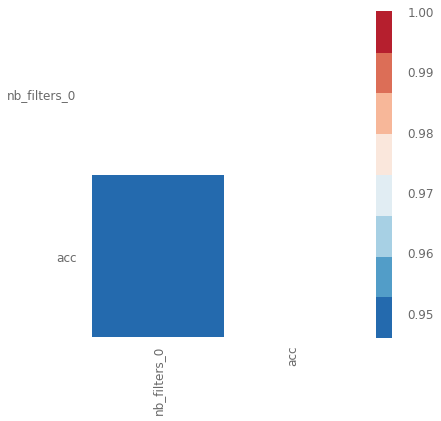

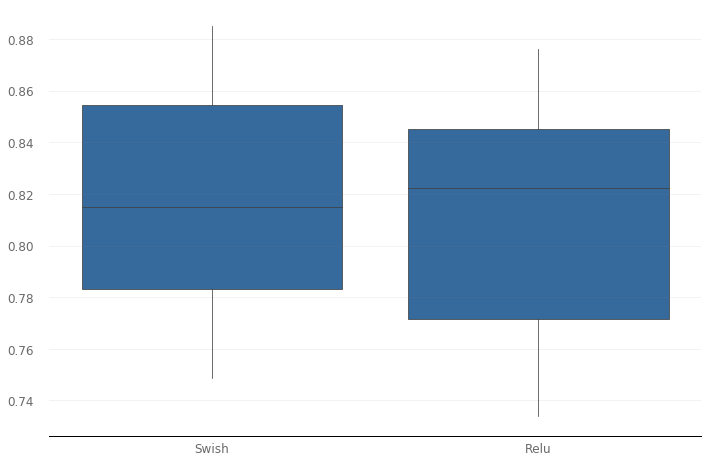

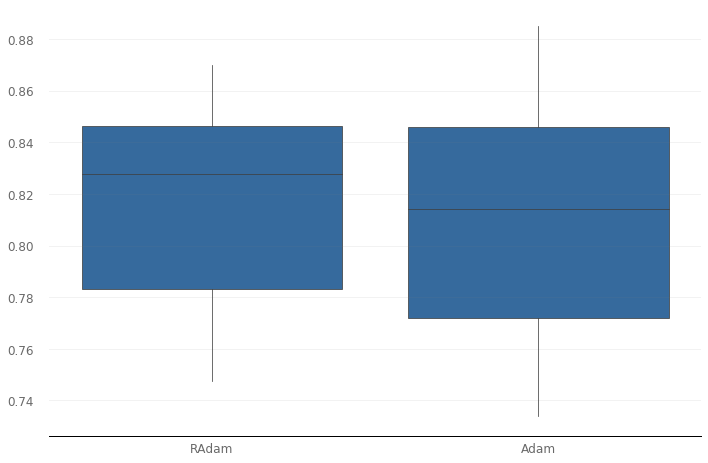

In [33]:
%matplotlib inline
r = ta.Reporting('2019-09-20.csv')

r.data.replace(to_replace=r"[<][a-z '_.]*(Swish'>)",value='Swish', inplace=True, regex=True)
r.data.replace(to_replace=r"[<][a-z '_.]*(ReLU'>)",value='Relu', inplace=True, regex=True)
r.data.replace(to_replace=r"[<][a-z '_.]*(RAdam'>)",value="RAdam", inplace=True, regex=True)
r.data.replace(to_replace=r"[<][a-z '_.]*(Adam'>)",value="Adam", inplace=True, regex=True)
r.data.drop(labels=["lr"], axis=1, inplace=True)
#r.data.drop(labels=["weighted_acc", "val_weighted_acc","lr", "decay","dropout","sigma_noise","lr.1"], axis=1, inplace=True)
#r.plot_corr('val_categorical_accuracy')
#r.best_params('val_categorical_accuracy')
r.plot_corr("acc", color_grades=5)
r.plot_box(x="act", y="acc")
r.plot_box(x="opt", y="acc")
#r.best_params()
r.table("acc", sort_by="acc")

In [89]:
import pickle
with open('talos_scan_object.pickle', mode='w+b') as f:
    pickle.dump(t, f)

In [95]:
#ta.Deploy(t,"U-nets", metric="acc")
#t.best_model(metric="acc")
from keras.models import model_from_json
custom_layers = {'Swish': Swish, 'RAdam': RAdam}
best_model = model_from_json(t.saved_models[7], custom_layers)
best_model.set_weights(t.saved_weights[7])
best_model.save("best_model.h5")
best_model.summary(line_length=127)

_______________________________________________________________________________________________________________________________
Layer (type)                             Output Shape                Param #         Connected to                              
input_layer (InputLayer)                 (None, None, None, 3)       0                                                         
_______________________________________________________________________________________________________________________________
block1_d_conv1 (Conv2D)                  (None, None, None, 64)      1792            input_layer[0][0]                         
_______________________________________________________________________________________________________________________________
block1_d_Swish1 (Swish)                  (None, None, None, 64)      0               block1_d_conv1[0][0]                      
________________________________________________________________________________________________________

In [4]:
# I/O Params
weight_path = "./weights/"
model_save_path = "./models/"

#IMG_ROWS, IMG_COLS, IMG_CHANNELS = (208, 208, 3)
IMG_ROWS, IMG_COLS, IMG_CHANNELS = (None, None, 3)
# architecture params
NB_FILTERS_0 = 32
SIGMA_NOISE = 0.01

# ****  deep learning model
SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
BATCH_SIZE = 16
NB_EPOCH = 600
NB_FROZEN = 40
VERBOSE = 0
# fit params
today_str = str(datetime.date.today())
DROP = 0

OPT_NAME = "adam"  # choices:adadelta; sgd, rmsprop, adagrad, adam
if OPT_NAME == "sgd":
    OPT = SGD(lr=0.1)
elif OPT_NAME == "rmsprop":
    OPT = RMSprop()
elif OPT_NAME == "adagrad":
    OPT = Adagrad()
elif OPT_NAME == "adadelta":
    OPT = Adadelta()
elif OPT_NAME == "adam":
    OPT = Adam(lr=1e-4, decay=0.0)
elif OPT_NAME == "amsgrad":
    OPT = Adam(lr=1e-4, amsgrad=True)
elif OPT_NAME == "adamax":
    OPT = Adamax()
elif OPT_NAME == "nadam":
    OPT = Nadam()
else:
    raise NameError("Wrong optimizer name")

train_tiles = [
    osp.splitext(osp.basename(i))[0]
    for i in glob(osp.join(data_path, train_path, "*.tif"))
]
val_tiles = [
    osp.splitext(osp.basename(i))[0]
    for i in glob(osp.join(data_path, val_path, "*.tif"))
]

train_generator = DataGenerator(
    osp.join(data_path, train_path),
    active_colors,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_cls,
    shuffle=True,
    augmenter=True,
)

val_generator = DataGenerator(
    osp.join(data_path, val_path),
    active_colors,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_cls,
    shuffle=True,
    augmenter=False,
)

test_generator = DataGenerator(
    osp.join(data_path, test_path),
    active_colors,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_cls,
    shuffle=True,
    augmenter=False,
)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from functools import partial
model_kwargs = {
    "nb_filters": NB_FILTERS_0,
    "sigma_noise": SIGMA_NOISE,
    "depth": 4,
    "initialization": "he_normal",
    "activation": Swish,
    "dropout": 0,
    "output_channels": num_cls,
    "class_weights": False,
    "batchnorm": True,
    "pre_bn": False,
    "arch": "U-Net",
    "pretrain": 0,
}
cat_fl = categorical_focal_loss()
w_dist_map = np.ones((num_cls, num_cls), dtype=np.float64)
np.fill_diagonal(w_dist_map, 0)
gw_dice = partial(generalised_wasserstein_dice_loss, weight_map=w_dist_map)
gw_dice.__name__ = 'GW_Dice_loss'
loss_func = tversky_ce
model_base_path = osp.join(model_save_path, today_str, loss_func.__name__, "arch-" + model_kwargs["arch"])

path_elements = [
    '{}_{}'.format(key, val.__name__)
    if hasattr(val, '__name__')
    else '{}_{}'.format(key, val) for key, val in model_kwargs.items()
]
path_elements.remove('{}_{}'.format("arch", model_kwargs["arch"]))
path_elements.insert(0, "reduced_classes")

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path, exist_ok=True)

modelpath = osp.join(
    model_base_path,
    '-'.join(path_elements) + ".h5"
)

log_path = osp.join(
    "./logs/",
    today_str,
    loss_func.__name__,
    model_kwargs["arch"],
    *path_elements, ''
)

try:
    del model
    sess = get_session()
    clear_session()
    sess.close()
    K.tensorflow_backend.set_session(tf.Session(config=config))
except NameError:
    print("[INFO]: Object 'model' does not exist")
    
if model_kwargs["pretrain"]:
    pretrain_model = osp.join(weight_path,"2019-09-20","pretrain_U-net_model.h5")
    #model = u_net(SHAPE, **model_kwargs)
    model = load_model(pretrain_model, custom_objects={'Swish': Swish})
    from keras.models import Model
    from keras.layers import Conv2D
    model_inputs = model.inputs
    model_preout = model.layers[-2].output
    new_output = Conv2D(num_cls, 1, activation="softmax", name="conv_out")(model_preout)
    model = Model(inputs=model.inputs, outputs=new_output)
    pretrain_layers = [
        "block{}_d_conv{}".format(block, layer)
        for block in range(1, 4 + 1)
        for layer in range(1, 3)
    ]
    for i, n in enumerate(pretrain_layers):
        model.get_layer(name=n).trainable = False
else:
    model = u_net(SHAPE, **model_kwargs)
print("{:^124}".format("Model name"))
print("{:^124}".format(model.name))
print("-"*124)
print(model.summary(line_length=124))
model.compile(loss=loss_func, optimizer=Adam(lr=1e-3, decay=0.0), metrics=["acc", jaccard1_coef])

[INFO]: Object 'model' does not exist
                                                         Model name                                                         
                                                          BSU-Net                                                           
----------------------------------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________________________________
Layer (type)                            Output Shape                Param #        Connected to                             
input_layer (InputLayer)                (None, None, None, 3)       0                                                       
____________________________________________________________________________________________________________________________
block1_d_conv1 (Conv2D)                 (None, None, None, 32)      896            inpu

In [8]:
print(model.loss_functions[0].__name__)
print(model.optimizer.__class__.__name__)
print(model.optimizer.get_config()['lr'])
print(len(model.layers), model.layers[33].name, model.layers[-1].output.shape[-1])

jaccard2_loss
Adam
0.0010000000474974513
68 block5_bottom_conv2 5


In [6]:
from keras_tqdm import TQDMNotebookCallback
from mmciad.utils.callbacks import PatchedModelCheckpoint

class_weights = [1 if k != 12 else 0 for k in active_labels]
#class_weights = [*cls_wgts.values()]
progressbar = TQDMNotebookCallback(
    metric_format="{name}: {value:0.4f}", leave_inner=True, leave_outer=True
)
tensor_board = TensorBoard(
    log_dir=log_path,
    histogram_freq=0,
    batch_size=BATCH_SIZE,
    write_graph=True,
    write_grads=False,
    write_images=True,
    embeddings_freq=0,
    update_freq="epoch"
)
early_stopper = EarlyStopping(monitor="loss", patience=40, verbose=1, mode="auto")
reducer = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
)
model_checkpoint = PatchedModelCheckpoint(
    modelpath, verbose=0, monitor="loss", save_best_only=True,
)
model_callbacks = [progressbar, tensor_board, early_stopper, reducer, model_checkpoint]

if model_kwargs["pretrain"]:
    frozen_history = model.fit_generator(
        generator=train_generator,
        epochs=NB_FROZEN,
        validation_data=val_generator,
        use_multiprocessing=True,
        workers=30,
        class_weight=class_weights,
        verbose=VERBOSE,
        callbacks=model_callbacks,
    )
    for n in pretrain_layers:
        model.get_layer(name=n).trainable = True

    model.compile(loss=loss_func, optimizer=Adam(lr=1e-4, decay=0.0), metrics=["acc", jaccard1_coef])


    history = model.fit_generator(
        generator=train_generator,
        epochs=NB_EPOCH,
        initial_epoch=NB_FROZEN,
        validation_data=val_generator,
        use_multiprocessing=True,
        workers=30,
        class_weight=class_weights,
        verbose=VERBOSE,
        callbacks=model_callbacks,
    )
else:
    history = model.fit_generator(
        generator=train_generator,
        epochs=NB_EPOCH,
        validation_data=val_generator,
        use_multiprocessing=True,
        workers=30,
        class_weight=class_weights,
        verbose=VERBOSE,
        callbacks=model_callbacks,
    )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...

Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 00201: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 00201: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 00211: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 00211: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 00233: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 00243: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 00243: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 00253: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00253: early stopping


In [10]:
#try:
#    del model
    #Clean session
#    sess = get_session()
#    clear_session()
#    sess.close()
#    K.tensorflow_backend.set_session(tf.Session(config=config))
#except NameError:
#    print("model does not exist")

#model = load_model(modelpath, custom_objects={'Swish': Swish, "tversky_ce": tversky_ce, "jaccard1_coef": jaccard1_coef, "jaccard2_loss": jaccard2_loss})

#for n in pretrain_layers:
#    model.get_layer(name=n).trainable = True

#model.compile(loss=loss_func, optimizer=Adam(lr=1e-4, decay=0.0), metrics=["acc", jaccard1_coef])


history = model.fit_generator(
    generator=train_generator,
    epochs=NB_EPOCH,
    initial_epoch=373,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    #class_weight=class_weights,
    verbose=VERBOSE,
    callbacks=model_callbacks,
)


Epoch 00406: ReduceLROnPlateau reducing learning rate to 1e-07.



Epoch 00416: ReduceLROnPlateau reducing learning rate to 1e-07.



Epoch 00426: ReduceLROnPlateau reducing learning rate to 1e-07.



Epoch 00436: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 00436: early stopping


In [ ]:
model = load_model(modelpath, custom_objects={'Swish': Swish})

history = model.fit_generator(
    generator=train_generator,
    epochs=NB_EPOCH,
    initial_epoch=66,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    class_weight=class_weights,
    verbose=VERBOSE,
    callbacks=model_callbacks,
)

In [22]:
# **** #####################################"
min_loss = np.argmin(history.history['loss'])
epoch_init = 65+1
print("Best loss: %.5f" % (np.min(history.history['loss'])))
print("at: %d" % (65+1+np.argmin(history.history['loss'])))
print(f"accuracy at {epoch_init+min_loss}:            {history.history['acc'][min_loss]:.5f}")
print(f"validation accuracy at {epoch_init+min_loss}: {history.history['val_acc'][min_loss]:.5f}")

Best loss: 0.07310
at: 372
accuracy at 372:            0.93676
validation accuracy at 372: 0.91100


In [24]:
model.save(modelpath.replace(".h5","-final.h5"))

In [190]:
# Find max accuracy of all models
best = {key: np.max(m.history["categorical_accuracy"]) for key, m in histories.items()}
print(best)
print(
    "Highest validation accuracy:\n{}, score: {}".format(
        max(best, key=lambda key: best[key]), max(best.values())
    )
)

{'categorical_crossentropy': 0.8944354446397887, 'weighted_categorical_crossentropy': 0.8308898773458269, 'tversky_loss': 0.8712075129151344, 'weighted_tversky_loss': 0.8665801187356313}
Highest validation accuracy:
categorical_crossentropy, score: 0.8944354446397887


In [ ]:
fig, ax1 = plt.subplots(2, 2, figsize=(10, 10))
i_s = [0, 0, 1, 1]
j_s = [0, 1, 0, 1]
lf = [
    "categorical_crossentropy",
    "weighted_categorical_crossentropy",
    "tversky_loss",
    "weighted_tversky_loss",
]
for i, j, m, title in zip(i_s, j_s, histories.values(), lf):
    loss = ax1[i, j].plot(m.epoch, m.history['loss'], label='loss')
    val_loss = ax1[i, j].plot(m.epoch, m.history['val_loss'], label='validation loss')
    ax1[i, j].set_title(title)
    if not j:
        ax1[i, j].set_ylabel('loss')
    if i:
        ax1[i, j].set_xlabel('epoch')
    ax2 = ax1[i, j].twinx()
    if j:
        ax2.set_ylabel('Accuracy')
    acc = ax2.plot(m.epoch, m.history['categorical_accuracy'], '-m', label='accuracy')
    val_acc = ax2.plot(m.epoch, m.history['val_categorical_accuracy'], '-g', label='validation accuracy')
    ax1[i, j].set_ylim(0.0, max([max(m.history['loss']), max(m.history['val_loss'])]))
    ax2.set_ylim(0.0, 1.0)
handles, labels = ax1[0, 0].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles=handles+handles2,
           bbox_to_anchor=(0., 0.02, 1., .1), # x, y, width, height
           loc='lower left',
           ncol=4, mode="expand")
#fig.tight_layout()
fig.suptitle('Training performance')
plt.show()
fig.savefig(osp.join(".","results","training performance.svg"), dpi=300,)

In [135]:
Y_pred = model.predict(X_test)

In [136]:
Y_pred.shape

(200, 208, 208, 6)

In [ ]:
def compare_results(img):
    if type(img) is list:
        cols = len(img)
        for pos, img in zip(range(1, cols * 3, 3), img):
            plt.subplot(cols, 3, pos)
            plt.imshow(X_test[img, :, :, :] * train_s + train_m)
            if pos <= 3:
                plt.title("Training image")
            plt.subplot(cols, 3, pos + 1)
            plt.imshow(colorvec[np.argmax(Y_test[img, :, :, :], axis=-1)])
            if pos <= 3:
                plt.title("Image label")
            plt.subplot(cols, 3, pos + 2)
            plt.imshow(colorvec[np.argmax(Y_pred[img, :, :, :], axis=-1)])
            if pos <= 3:
                plt.title("Label prediction")
            pred_list = np.unique(np.argmax(Y_pred[img, :, :, :], axis=-1))
            test_list = np.unique(np.argmax(Y_test[img, :, :, :], axis=-1))
            print("{:^44s}".format("Image " + str(img)))
            print(
                "{:<3s}{:<18s}{:<3s}{:<18s}".format(
                    "", "Actual labels", "", "Predicted labels:"
                )
            )
            print("-" * 44)
            for i in active_labels:
                a = ""
                p = ""
                j = ""
                k = ""
                if i in test_list:
                    j = str(i)
                    a = active_classes[i]
                if i in pred_list:
                    k = str(i)
                    p = active_classes[i]
                if not a == p == j == k:
                    print("{:<3s}{:<18s}{:<3s}{:<18s}".format(j, a, k, p))
    else:
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[img, :, :, :] * train_s + train_m)
        plt.title("Training image")
        plt.subplot(1, 3, 2)
        plt.imshow(colorvec[np.argmax(Y_test[img, :, :, :], axis=-1)])
        plt.title("Image label")
        plt.subplot(1, 3, 3)
        plt.imshow(colorvec[np.argmax(Y_pred[img, :, :, :], axis=-1)])
        plt.title("Label prediction")


# compare_results([1,4,7,28])
for i in range(Y_pred.shape[0]):
    compare_results(i)
    plt.savefig("./figures/test_prediction_tile{}.png".format(i), format="png")

In [ ]:
# Quantitative evaluation
from dlia_tools.eval import jaccard
Y_test_pred = model.predict(X_test)
#Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

#print("Jaccard on training set:", jaccard(Y_train, Y_train_pred))
print("Jaccard on validation set:", jaccard(Y_val, Y_val_pred))
print("Jaccard on test set:", jaccard(Y_test, Y_test_pred))

In [15]:
#model.save_weights(path+'batchnorm-weights.npy')

In [8]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[1] - windowSize[0] + stepSize, stepSize):
        for x in range(0, image.shape[0] - windowSize[1] + stepSize, stepSize):
            # yield the current window
            res_img = image[x : x + windowSize[0], y : y + windowSize[1]]
            change = False
            if res_img.shape[1] != windowSize[1]:
                y = image.shape[1] - windowSize[1]
                change = True
            if res_img.shape[0] != windowSize[0]:
                x = image.shape[0] - windowSize[0]
                change = True
            if change:
                res_img = image[x : x + windowSize[0], y : y + windowSize[1]]
            yield (x, y, x + windowSize[0], y + windowSize[1], res_img)


def predict_window(model, img, step_size=1000, wsize=1024, num_class=11):
    size = Size(img.shape[0], img.shape[1])
    dtype = img.dtype
    if (size.x > wsize) & (size.y > wsize):
        output_img = np.zeros(shape=(size.x, size.y, num_class))
        output_img[:] = np.nan
        for (x, y, dx, dy, I) in sliding_window(img, step_size, (wsize, wsize)):
            window_prediction = model.predict(np.expand_dims(I, axis=0))
            try:
                output_img[x:dx, y:dy] = np.nanmean(
                    np.stack((output_img[x:dx, y:dy], np.squeeze(window_prediction)), axis=0), axis=0
                ).astype(dtype)
            except ValueError:
                print(dx-x, dy-y,'\n', window_prediction.shape)
                break
        return output_img
    output_img = model.predict(img)
    return output_img

def evaluate_window(model, slide, target, stepSize=1000, wsize=1024, batch_size=None, num_cls=11):
    X, Y, _ = slide.shape
    if (X > wsize) & (Y > wsize):
        input_tiles = []
        target_tiles = []
        for (x, y, dx, dy, I) in sliding_window(slide, wsize, (wsize, wsize)):
            input_tiles.append(I)
            target_tiles.append(target[x:dx,y:dy])
        input_tiles = np.asarray(input_tiles)
        target_tiles = np.asarray(target_tiles)
        if batch_size is None:
            batch_size = input_tiles.shape[0]
        print(target_tiles.shape)
        return model.evaluate(x=input_tiles, y=target_tiles, batch_size=batch_size)
    else:
        return model.evaluate(x=slide, y=target, batch_size=1)


def concat_windows(slides, targets, stepSize=1000, wsize=1024):
    input_tiles = []
    target_tiles = []
    for slide, target in zip(slides, targets):
        X, Y, _ = slide.shape
        if (X > wsize) & (Y > wsize):
            for (x, y, dx, dy, I) in sliding_window(slide, wsize, (wsize, wsize)):
                input_tiles.append(I)
                target_tiles.append(target[x:dx,y:dy])
    input_tiles = np.asarray(input_tiles)
    target_tiles = np.asarray(target_tiles)
    return input_tiles, target_tiles

def find_contrast_min_and_max(img):
    AUTO_THRESHOLD = 5000
    pixcount = img.size
    limit = pixcount/10
    threshold = pixcount/AUTO_THRESHOLD
    n_bins = 256
    values, histogram = np.histogram(img, n_bins)
    i = 0 # start at zero rather than -1 to avoid accounting for empty patches
    found = False
    count = 0
    while True:
        i += 1
        count = values[i]
        if count>limit:
            count = 0
        found = count> threshold
        if found or i>=255:
            break
    hmin = i
    found = False
    i = 256
    while True:
        i -= 1
        count = values[i]
        if count>limit:
            count = 0
        found = count> threshold
        if found or i<1:
            break
    hmax = i
    return hmin/256, hmax/256

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

lag = 10
threshold = 2
influence = 0

def auto_contrast(img, order=['b','r','g']):
    from skimage import exposure
    from scipy import stats
    output_img = np.zeros_like(np.squeeze(img))
    CHANNEL_INDEX = {'r': 0, 'g': 1, 'b': 2}
    ch = ['red','green','blue']
    for i, c in enumerate([CHANNEL_INDEX[channel] for channel in order]):
        v_min, v_max = find_contrast_min_and_max(img[..., i])
        hist, bins_ = np.histogram(img[..., i], bins=256)
        t = thresholding_algo(hist, lag, threshold, influence)
        v_min = t["signals"].argmax()/256
        #midpoint = v_max - v_min
        #v_min = midpoint - 30/256.
        #print(ch[c], "(c: {})".format(c), order[i], "(i: {})".format(i))
        #print("before:",v_min, v_max)
        if c == 0:
            v_min = (t["signals"].argmax()+1)/256
            #v_max = np.percentile(img[..., i], (95.0))
        elif c == 1:
            v_min = t["signals"].argmax()/256
        elif c == 2:
            v_min = (t["signals"].argmax())/256
            #print(t["signals"])
            #v_min *= 1.3
            #v_min = max(v_min, np.percentile(img[..., i], (40.0)))
            #v_max = np.percentile(img[..., i], (98.0))
        #print("after:",v_min, v_max)
        output_img[..., c] = exposure.rescale_intensity(img[..., i], in_range=(v_min, v_max))
    return output_img

In [11]:
from mmciad.utils.preprocessing import merge_labels
test_slides, test_targets = load_slides_as_dict(path, "test", train_m, train_s, [x_min, x_max], "gt", num_cls, colorvec)
raw_test_slides = load_slides_as_dict(path, "test")
#remap_pattern = {0: [0, ], 1: [2, 3, 5], 2: [7, 8, 9], 3: [10, 1, 4, 6]}
#bin_class = len(remap_pattern)
#binary_test_targets = {name: to_categorical(merge_labels(np.argmax(img, axis=-1), remap_pattern)) for name, img in test_targets.items()}

In [19]:
#print(test_slides["N9a-1"].min(), test_slides["N9a-1"].max())
#print(170775/test_slides["N10a"].shape[1])
print(test_targets.keys())

dict_keys(['N4b', 'N5', 'T4b-1'])


In [98]:
hist, bins_ = np.histogram(raw_test_slides["N4b"][..., 1], bins=256)
t = thresholding_algo(hist, lag, threshold, influence)
hist
t["signals"].argmax()

21

N4b
N5
T4b-1


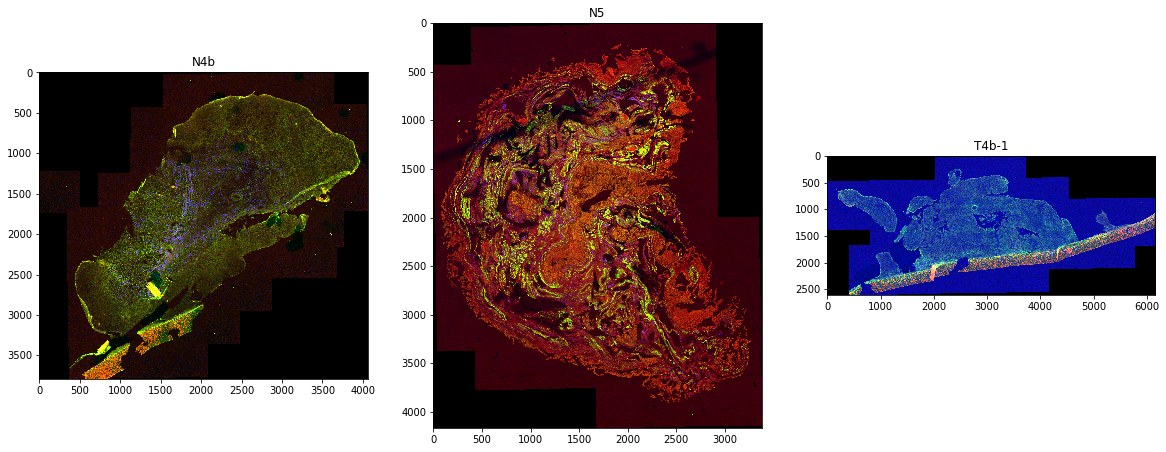

In [117]:
from skimage import exposure
from scipy import stats
num_slides = len(raw_test_slides)
plt.rcParams['figure.figsize'] = (20.0, 16.0)
enhanced_slides = {}
for n, (name, slide) in enumerate(raw_test_slides.items(), 1):
    print(name)
    #for i, c in enumerate([1,2,0]):
        #zero = stats.percentileofscore(slide[..., c].ravel(), 0)
        #mid = stats.percentileofscore(slide[..., c].ravel(), np.median(slide[..., c].ravel()))
        #print("channel {}: {}".format(i, zero))
        #v_min, v_mid, v_max = np.percentile(slide, (zero+10, mid, 90.0))
        #print("channel {}: min {} , mid {} , max {}".format(i, v_min, v_mid, v_max))
        #v_min, v_max = find_contrast_min_and_max(slide[..., c])
        #print("channel {}: min {} , max {}".format(i, v_min, v_max))
        #enhanced_slides[name][..., i] = exposure.rescale_intensity(slide[..., c], in_range=(v_min, v_max))
    enhanced_slides[name] = auto_contrast(slide)
    plt.subplot(1, num_slides, n)
    plt.imshow(enhanced_slides[name])
    plt.title(name)
plt.show()

In [66]:
train_slides = load_slides_as_dict(path, train_path, train_m, train_s, False)
train_slides.keys()

dict_keys(['N11b', 'N15b-1', 'N15b-2', 'N8b', 'N8c', 'N9a-2', 'T13a', 'T8b'])

In [34]:
test_slides.pop('N10a')
test_slides.pop('N4b')
#test_slides.pop('N9a-1')
test_slides.keys()

dict_keys(['N9a-1', 'T4a'])

In [18]:
weight_path = "./weights/"
results_path = "./results/"
train_date = "2019-12-10"
weights = sorted(glob(osp.join(weight_path, train_date,"*","*", "*.h5")), key=str.lower)

#eval_kwargs = model_kwargs
#eval_kwargs["activation"] = Swish
#eval_kwargs["output_channels"] = num_cls
#del model
#model = load_model(weights[0], custom_objects={'Swish': Swish,'categorical_focal_loss_fixed': categorical_focal_loss()})
for name, target in test_targets.items():
    slide = np.squeeze(test_slides[name])
    #with tf.device('/cpu:*'): # Remember to re-indent model + compile below
    print(name, target.shape)
    print(model.metrics_names)
    print(evaluate_window(model, slide, target, stepSize=190, wsize=208, batch_size=12))

N4b (3787, 4061, 5)
['loss', 'acc', 'jaccard1_coef']
(380, 208, 208, 5)
380/380 [==============================] - 4s 11ms/step
[0.8471429447177797, 0.8071485262168081, 0.69283598598681]
N5 (4164, 3378, 5)
['loss', 'acc', 'jaccard1_coef']
(357, 208, 208, 5)
357/357 [==============================] - 4s 10ms/step
[1.3704468544353456, 0.7743840733496081, 0.6334626163755145]
T4b-1 (2604, 6162, 5)
['loss', 'acc', 'jaccard1_coef']
(390, 208, 208, 5)
390/390 [==============================] - 4s 10ms/step
[0.6602048679613151, 0.8721935556485103, 0.7577235212692848]


In [12]:
weight_path = "./weights/"
results_path = "./results/"
train_date = "2019-12-10"
weights = sorted(glob(osp.join(weight_path, train_date,"*","*", "*.h5")), key=str.lower)
# architecture params
NB_FILTERS_0 = 64
SIGMA_NOISE = 0.01

VERBOSE = 1
model_kwargs = {
    "nb_filters": NB_FILTERS_0,
    "sigma_noise": SIGMA_NOISE,
    "depth": 4,
    "maxpool": False,
    "initialization": "he_normal",
    "activation": "Swish",
    "dropout": 0,
    "batchnorm": True,
    "arch": "U-Net",
}
eval_kwargs = model_kwargs
eval_kwargs["activation"] = Swish
eval_kwargs["output_channels"] = num_cls
slide_list = []
target_list = []
for name, target in test_targets.items():
    slide_list.append(np.squeeze(test_slides[name]))
    target_list.append(target)
input_tiles, target_tiles = concat_windows(slide_list, target_list, stepSize=190, wsize=208)
#with tf.device('/cpu:*'): # Remember to re-indent model + compile below
#    eval_model = load_model(weights[0], custom_objects={'Swish': Swish})
#    eval_model.compile(
#        loss=categorical_crossentropy,
#        optimizer=Adam(lr=0.001, decay=0),
#        metrics=["acc"],
#    )
#    print(target.shape)
test_metrics = model.evaluate(x=input_tiles, y=target_tiles, batch_size=12)
print(test_metrics)

1127/1127 [==============================] - 5s 5ms/step
[0.28461023205238417, 0.7971147566425557, 0.6628602121187293]


In [22]:
from sklearn.metrics import jaccard_score
from collections import namedtuple
from pathlib import Path

Size = namedtuple("Size", ["x", "y"])
weight_path = "./weights/"
results_path = "./results/"
train_date = "2019-12-10"
weights = sorted(glob(osp.join(weight_path, train_date,"*","*", "*.h5")), key=str.lower)

loss_dir = str(osp.split(modelpath)[0]).split('/')[-2]
arch_dir = str(osp.split(modelpath)[0]).split('/')[-1]
base_name = osp.split(modelpath)[-1]
class_wgt_dir = 'weights_{}'.format('True' in str(base_name))
act_dir = '{}'.format(base_name[base_name.rfind('activation_'):base_name.find('-dropout_')])
init_dir = '{}'.format(base_name[base_name.rfind('initialization_'):base_name.find('-activation_')])
#pre_dir = '{}'.format(base_name[base_name.rfind('pretrain_'):base_name.find('-sigma_')])
print({v: k for k, v in class_map.items() if v in active_labels})
for name, target in test_targets.items():
    slide = np.squeeze(test_slides[name])
    #with tf.device('/cpu:*'): # Remember to re-indent model + compile below
        #test_model = load_model(weights[0], custom_objects={'Swish': Swish})

        #test_model.compile(
        #    loss=categorical_crossentropy,
        #    optimizer=Adam(lr=0.001, decay=0),
        #    metrics=["acc"],
        #)
    print(target.shape)
    output = predict_window(model, slide, step_size=190, wsize=208, num_class=5)
    prediction = colorvec[np.argmax(output, axis=-1)]
    res_path = osp.join(
        results_path,
        train_date,
        name,
        loss_dir,
        arch_dir,
        Path(modelpath).stem
    )
    if not osp.exists(res_path):
        os.makedirs(res_path)
    imsave(res_path + "/result_argmax.png", prediction.astype(np.uint8), check_contrast=False)
    target_byte = np.argmax(test_targets[name], axis=-1)
    jaccard_labels = active_labels[1:3]+list((active_labels[-1],))
    jaccard = jaccard_score(np.ndarray.flatten(np.argmax(output, axis=-1)),
                            np.ndarray.flatten(target_byte),
                            average=None)
    print(jaccard)

{0: 'Background', 1: 'Other', 11: 'Cancer', 12: 'IGNORE', 13: 'Healthy'}
(3787, 4061, 5)
[0.96054323 0.68053635 0.         0.32955337 0.12262931]
(4164, 3378, 5)
[0.92773791 0.6447108  0.         0.1135615  0.00149886]
(2604, 6162, 5)
[0.98119665 0.43887065 0.74189967 0.42982909 0.01864557]


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee7066c4a8>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


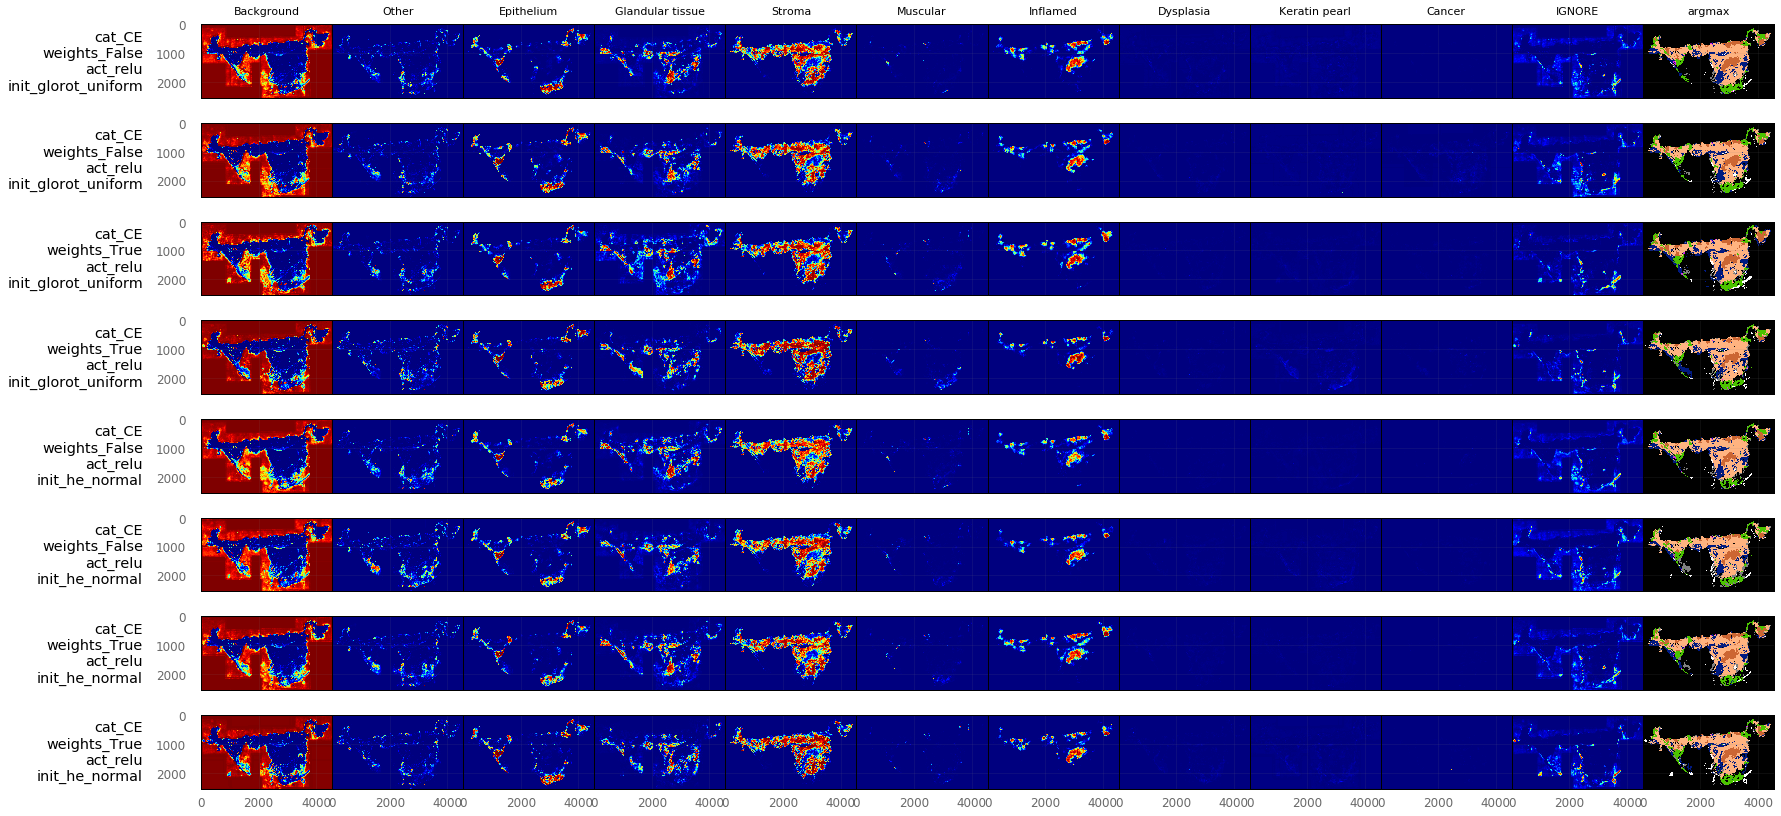

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee7052fac8>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


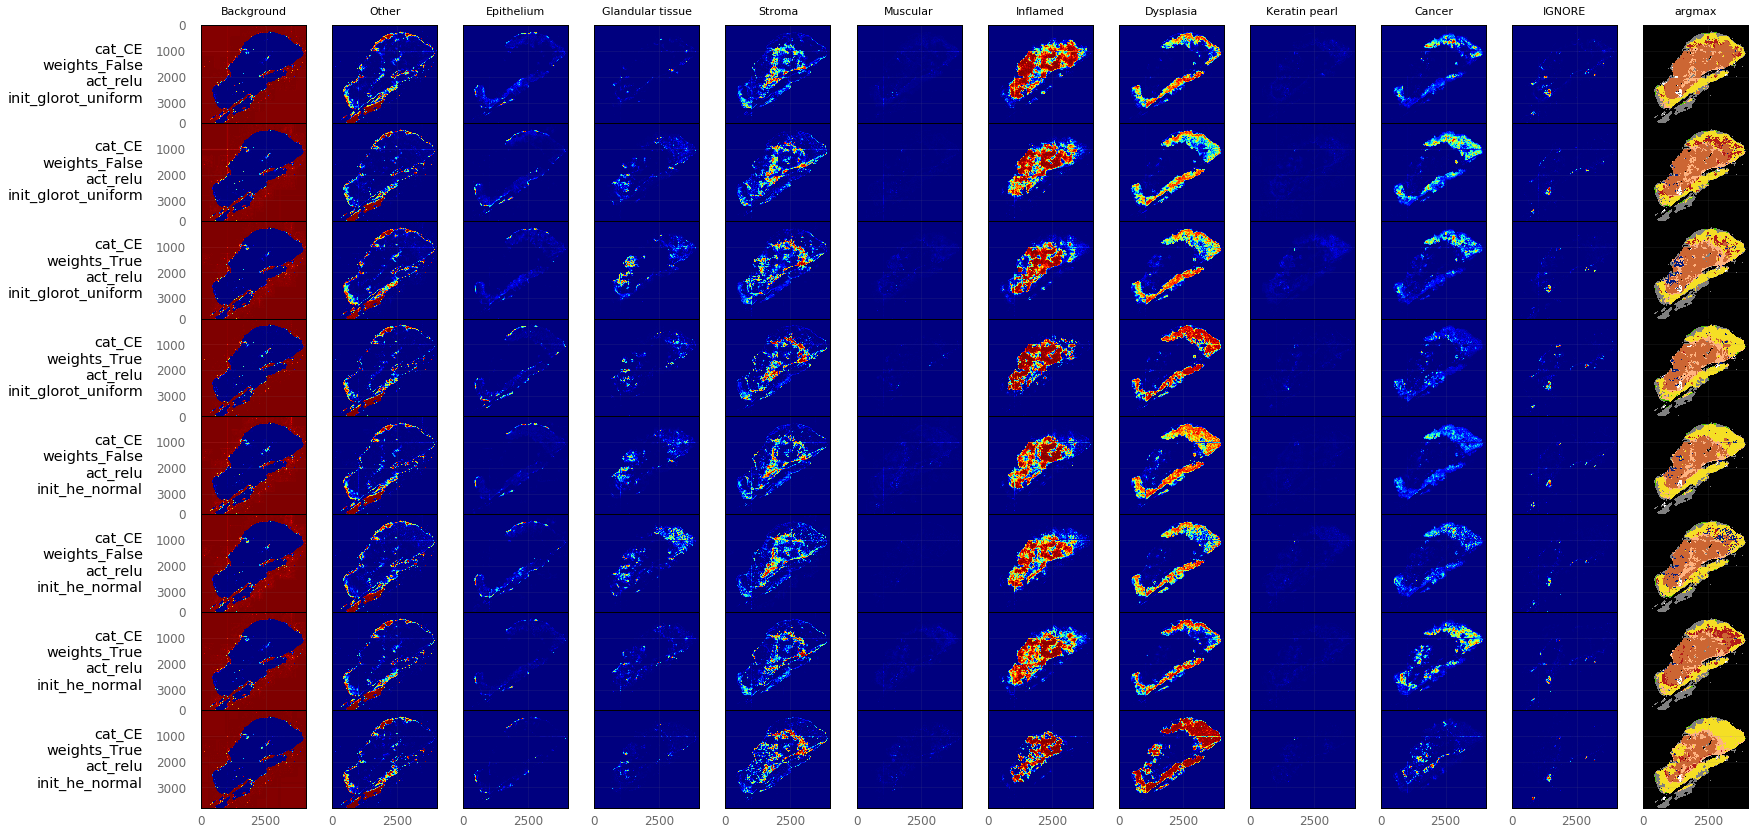

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee00617208>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


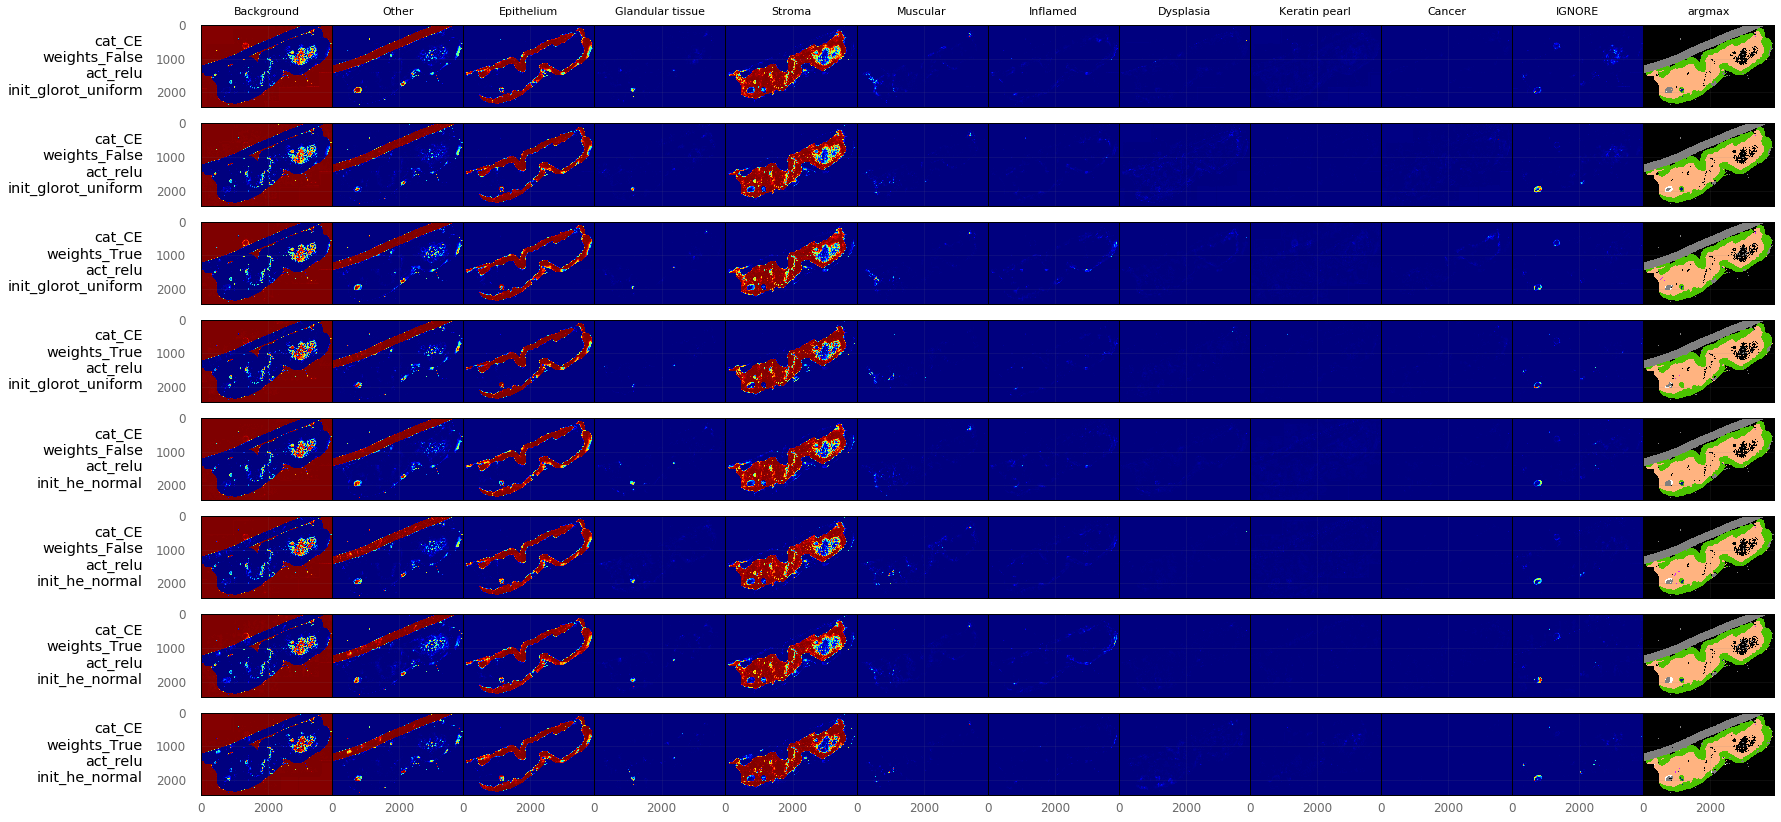

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee2c3549b0>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


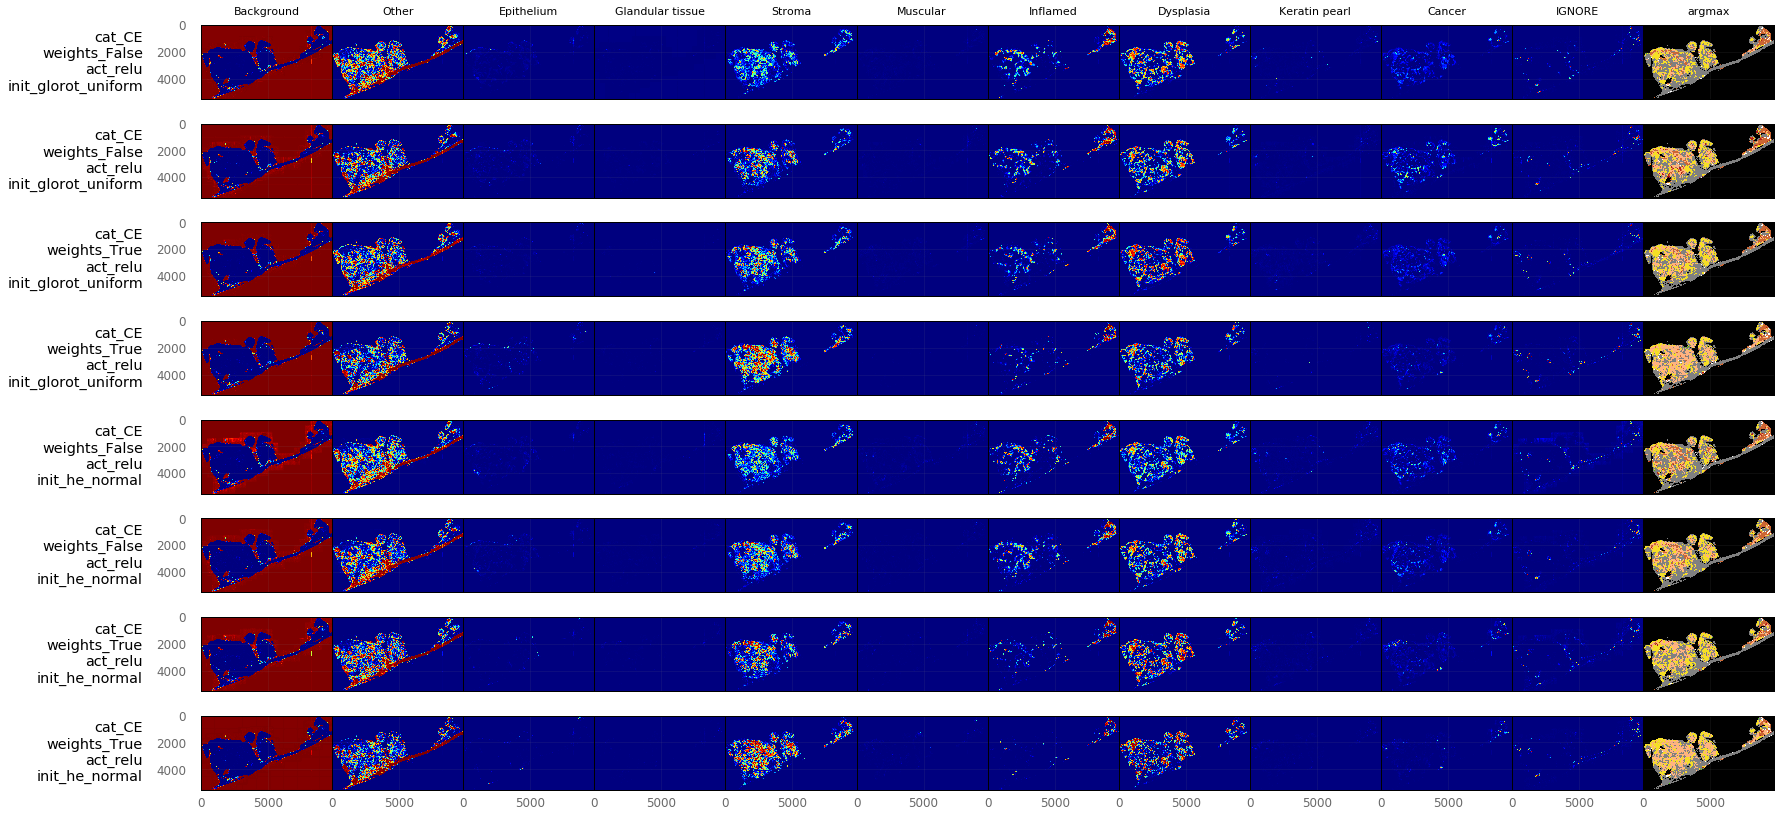

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fed56596ac8>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


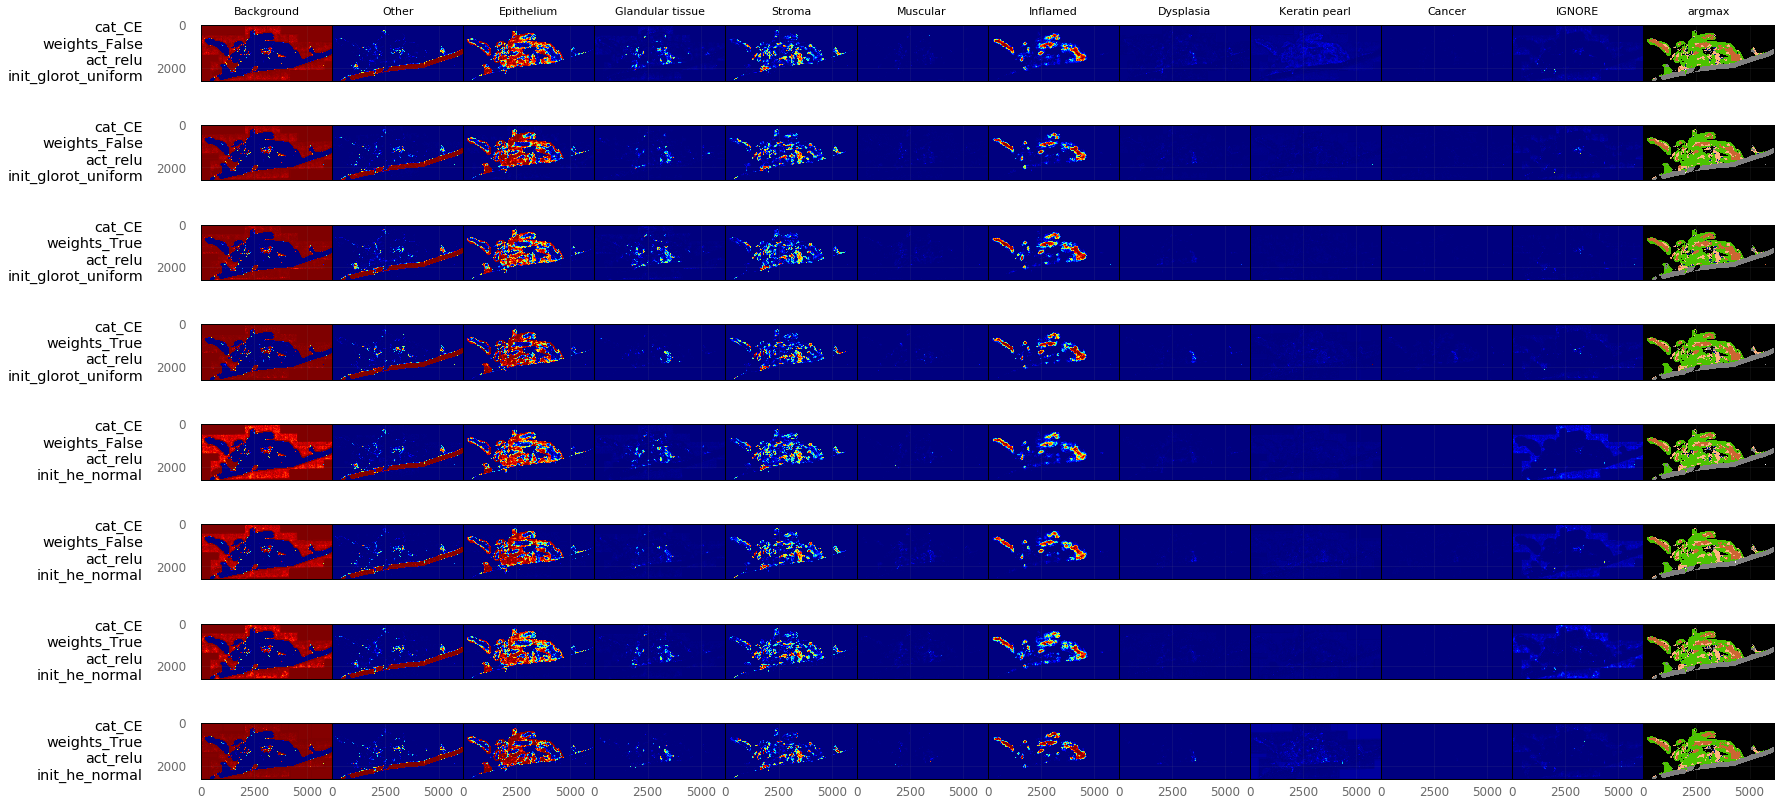

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee7051ceb8>>
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


KeyboardInterrupt: 

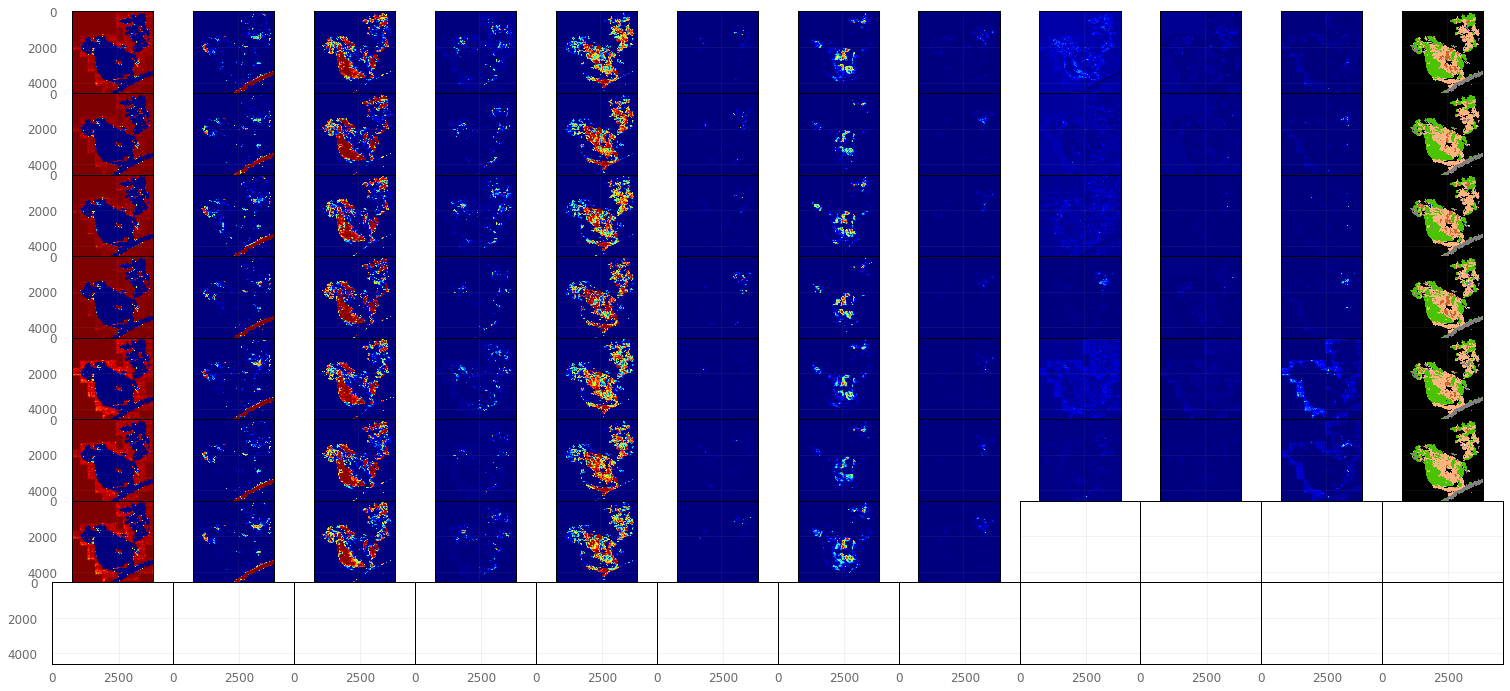

In [21]:
def talos_predict_window(slide, model_id=None, stepSize=500, wsize=512):
    X, Y, _ = slide.shape
    if (X > wsize) & (Y > wsize):
        output = np.ones(shape=(X, Y, num_cls))
        for (x, y, dx, dy, I) in sliding_window(slide, wsize, (wsize, wsize)):
            prediction = p.predict(np.expand_dims(I, axis=0), model_id)
            output[x:dx, y:dy, :] = prediction
        return output
    else:
        output = p.predict(np.expand_dims(slide, axis=0), model_id)
        return output
import pickle
#with open("./weights/talos.pickle", 'wb') as f:
#    pickle.dump(t, f, -1)

from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable

try:
    del t # this is from global space - change this as you need
except:
    pass

#with open("./weights/talos.pickle", 'rb') as f:
#    t = pickle.load(f)
def batch(iterable, n=1):
    l = len(iterable)
    counter = 0
    for ndx in range(0, l, n):
        counter += 1
        yield counter, iterable[ndx:min(ndx + n, l)]


plt.rcParams['figure.figsize'] = (26.0, 38.0)
weight_path = "./weights/"
results_path = "./results/"
train_date = "2019-07-05"
weights = sorted(glob(osp.join(weight_path, train_date,"cat_CE", "*.h5")), key=str.lower)
for count, b in batch(weights, 8):
    
    row_titles = []

    pad = 5 # in points
    #test_name = "T4a"
    try:
        for test_name, slide in test_slides.items():
            sess = get_session()
            clear_session()
            sess.close()
            sess = get_session()
            
            config = tf.ConfigProto()
            config.gpu_options.allow_growth = True
            K.tensorflow_backend.set_session(tf.Session(config=config))
            #with tf.device('/cpu:*'): # Remember to re-indent model + compile below
            model = u_net(
                (None, None, 3),
                64,
                sigma_noise=0,
                depth=4,
                dropout=0,
                output_channels=num_cls,
                batchnorm=True,
                pretrain=0,
            )

            model.compile(
                loss=categorical_crossentropy,
                optimizer=Adam(lr=0.001, decay=0),
                metrics=["acc"],
            )

            fig, axes = plt.subplots(
                nrows=len(b),
                ncols=num_cls+2,
                sharex=True,
                sharey=True,
                figsize=(26, 1.5*len(b)),
                gridspec_kw={'hspace': 0, 'wspace': 0}
            )
            for i, w in enumerate(b):
                loss_dir = str(osp.split(w)[0]).split('/')[-1].split('-')[0]
                base_name = osp.split(w)[-1]
                class_wgt_dir = 'weights_{}'.format('True' in str(base_name))
                act_dir = '{}'.format(base_name[base_name.rfind('act_'):base_name.find('-decay_')])
                init_dir = '{}'.format(base_name[base_name.rfind('init_'):base_name.find('-act_')])
                res_path = osp.join(
                    results_path,
                    train_date,
                    test_name,
                    loss_dir,
                    ' '.join([class_wgt_dir, init_dir, act_dir])
                )
                row_titles.append(loss_dir + '\n' + class_wgt_dir + '\n' +  act_dir + '\n' +  init_dir)
                if not osp.exists(res_path):
                    os.makedirs(res_path)
                model.load_weights(w)
                output = predict_window(slide)
                for j in range(num_cls):
                    axes[i, j].imshow(output[:,:,j], cmap="jet")
                    plt.imsave(res_path + "/result-{}.png".format(active_classes[j]), output[:,:,j], cmap="jet")
                axes[i, num_cls].imshow(colorvec[np.argmax(output, axis=-1)])
                imsave(res_path + "/result_argmax.png", colorvec[np.argmax(output, axis=-1)].astype(np.uint8), check_contrast=False)
                axes[i, num_cls+1].imshow(slide[...,[1,2,0]])

            for ax, col in zip(axes[0], active_classes + ["argmax", "input"]):
                ax.set_title(col)

            for ax, row in zip(axes[:,0], row_titles):
                ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', wrap=True)
            fig.tight_layout(pad=1.5)
            fig.subplots_adjust(left=0.15, top=0.95)
            plt.show()
            fig.savefig(osp.join("./results", train_date, test_name + "-" + str(count) + "-overview.png"))
            fig.clear()
            plt.close()
    except Exception as e:
        logger.error(str(e))
        logger.error(traceback.format_exc())
        raise

dict_keys(['N4b', 'T4a'])
slide: (3787, 4061, 3)
prediction_byte: (3787, 4061)
test_target: (3787, 4061, 11)
test_target_byte: (3787, 4061)
slide: (5532, 9787, 3)
prediction_byte: (5532, 9787)
test_target: (5532, 9787, 11)
test_target_byte: (5532, 9787)


Exception in thread Thread-6307:
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Pop

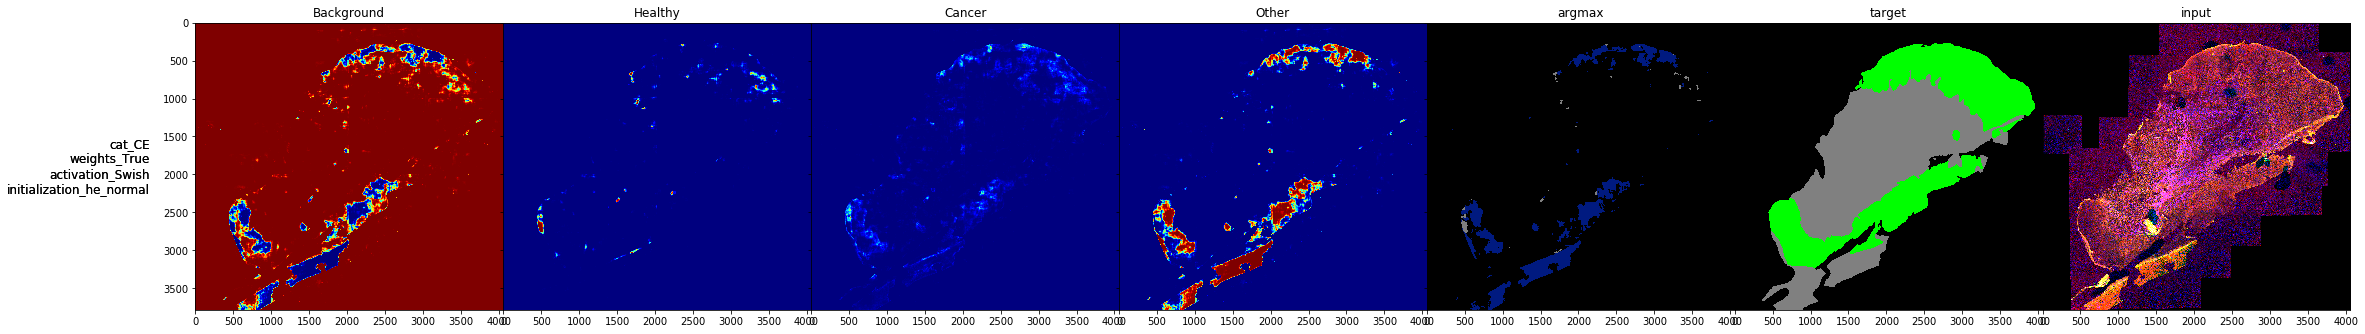

MemoryError: 

<Figure size 6165.81x497.88 with 7 Axes>

MemoryError: 

In [102]:
from sklearn.metrics import jaccard_score
from collections import namedtuple

Size = namedtuple("Size", ["x", "y"])

weight_path = "./weights/"
results_path = "./results/"
train_date = "2019-10-31"
weights = sorted(glob(osp.join(weight_path, train_date,"*","*", "*.h5")), key=str.lower)
#weights = [modelpath]
INV_DPI = 1/100
SCALE = 1/8

from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable

def batch(iterable, n=1):
    l = len(iterable)
    counter = 0
    for ndx in range(0, l, n):
        counter += 1
        yield counter, iterable[ndx:min(ndx + n, l)]

def run_prediction(input_dict, target_dict, classes, colors, weight_list):
    subslides = {}
    num_classes = len(classes)
    for name in target_dict.keys(): #["N9a-1", "T4a"]:#"N10a", "T4b-1", "T4b-2"]:
        subslides[name] = input_dict[name]
    print(subslides.keys())
    prediction_byte = {}
    jaccard = {}
    jaccard_weighted = {}
    jaccard_weighted_nobg = {}

    for count, b in batch(weight_list, 8):
        row_titles = []
        col_titles = classes.copy()
        col_titles.extend(["argmax", "target", "input"])

        pad = 5 # in points
        #test_name = "T4a"
        try:
            fig, axes = {}, {}
            for name, slide in subslides.items():
                slide = np.squeeze(slide)
                input_width = slide.shape[1]
                input_height = slide.shape[0]
                num_columns = num_classes+3
                fig_width = input_width*INV_DPI*SCALE
                fig_height = input_height*INV_DPI*SCALE
                fig[name], axes[name] = plt.subplots(
                    nrows=1,
                    ncols=num_columns,
                    sharex=True,
                    sharey=True,
                    figsize=(fig_width*num_columns, fig_height),
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                )
            for i, w in enumerate(b):
                #sess = get_session()
                #clear_session()
                #sess.close()
                #sess = get_session()

                #config = tf.ConfigProto()
                #config.gpu_options.allow_growth = True
                #K.tensorflow_backend.set_session(tf.Session(config=config))
                with tf.device('/cpu:*'): # Remember to re-indent model + compile below
                #model = u_net(
                #    (None, None, 3),
                #    64,
                #    sigma_noise=0,
                #    depth=4,
                #    dropout=0,
                #    output_channels=num_cls,
                #    batchnorm=True,
                #    pretrain=0,
                #)
                    test_kwargs = model_kwargs
                    test_kwargs["activation"] = Swish
                    test_kwargs["output_channels"] = num_cls

                #test_model = u_net(SHAPE, **test_kwargs)
                    test_model = load_model(w, custom_objects={'Swish': Swish})

                    test_model.compile(
                        loss=categorical_crossentropy,
                        optimizer=Adam(lr=0.001, decay=0),
                        metrics=["acc"],
                    )

                for test_name, slide in subslides.items():
                    slide = np.squeeze(slide)
                    loss_dir = str(osp.split(w)[0]).split('/')[-2]
                    arch_dir = str(osp.split(w)[0]).split('/')[-1]
                    base_name = osp.split(w)[-1]
                    class_wgt_dir = 'weights_{}'.format('True' in str(base_name))
                    act_dir = '{}'.format(base_name[base_name.rfind('activation_'):base_name.find('-dropout_')])
                    init_dir = '{}'.format(base_name[base_name.rfind('initialization_'):base_name.find('-activation_')])
                    #pre_dir = '{}'.format(base_name[base_name.rfind('pretrain_'):base_name.find('-sigma_')])
                    res_path = osp.join(
                        results_path,
                        train_date,
                        test_name,
                        loss_dir,
                        arch_dir,
                        ' '.join([class_wgt_dir, init_dir, act_dir])
                    )
                    row_titles.append(loss_dir + '\n' + class_wgt_dir + '\n' +  act_dir + '\n' +  init_dir)
                    if not osp.exists(res_path):
                        os.makedirs(res_path)
                    raw_input = auto_contrast(slide)
                    #test_model.load_weights(w)
                    print(f"slide: {slide.shape!s:>10}")
                    output = predict_window(test_model, slide, num_class=num_classes)
                    prediction = colorvec[np.argmax(output, axis=-1)]
                    prediction_byte[test_name] = np.argmax(output, axis=-1)
                    target_byte = np.argmax(target_dict[test_name], axis=-1)
                    print(f"prediction_byte: {prediction_byte[test_name].shape!s:>10}")
                    print(f"test_target: {test_targets[test_name].shape!s:>10}")
                    print(f"test_target_byte: {target_byte.shape!s:>10}")
                    jaccard[test_name] = jaccard_score(np.ndarray.flatten(prediction_byte[test_name]),
                                                       np.ndarray.flatten(target_byte),
                                                       average=None)
                    jaccard_weighted[test_name] = jaccard_score(np.ndarray.flatten(prediction_byte[test_name]),
                                                       np.ndarray.flatten(target_byte),
                                                       average='weighted')
                    jaccard_weighted_nobg[test_name] = jaccard_score(np.ndarray.flatten(prediction_byte[test_name]),
                                                       np.ndarray.flatten(target_byte),
                                                       labels=active_labels[1:],
                                                       average='weighted')
                    if len(b) == 1:
                        for j in range(num_classes):
                            axes[test_name][j].imshow(output[:,:,j], cmap="jet")
                            plt.imsave(res_path + "/result-{}.png".format(classes[j]), output[:,:,j], cmap="jet")
                        axes[test_name][num_classes].imshow(prediction)
                        axes[test_name][num_classes+1].imshow(colors[target_byte])
                        axes[test_name][num_classes+2].imshow(raw_input)
                    else:
                        for j in range(num_classes):
                            axes[test_name][i, j].imshow(output[:,:,j], cmap="jet")
                            plt.imsave(res_path + "/result-{}.png".format(classes[j]), output[:,:,j], cmap="jet")
                        axes[test_name][i, num_classes].imshow(prediction)
                        axes[test_name][i, num_classes+1].imshow(colors[target_byte])
                        axes[test_name][i, num_classes+2].imshow(raw_input)
                    imsave(res_path + "/result_argmax.png", prediction.astype(np.uint8), check_contrast=False)
                    imsave(res_path + "/result_input.png", np.array(raw_input*256., dtype=np.uint8), check_contrast=False)

            for name in subslides.keys():
                if len(b) == 1:
                    for ax, col in zip(axes[name][:], col_titles):
                        ax.set_title(col)
                    for row in row_titles:
                        axes[name][0].annotate(row, xy=(0, 0.5), xytext=(-axes[name][0].yaxis.labelpad - pad, 0),
                        xycoords=axes[name][0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', wrap=True)
                else:
                    for ax, col in zip(axes[name][0], col_titles):
                        ax.set_title(col)
                    for ax, row in zip(axes[name][:,0], row_titles):
                        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', wrap=True)
                fig[name].tight_layout(pad=1.5)
                fig[name].subplots_adjust(left=0.15, top=0.95)
                plt.show()
                fig[name].savefig(osp.join("./results", train_date, name + "-" + str(count) + "-overview.png"))
                fig[name].clear()
                plt.close()
        except Exception as e:
            logger.error(str(e))
            logger.error(traceback.format_exc())
            raise

merged_classes = ['Background', "Healthy", "Cancer", "Other"]
merged_colors = np.array([[0, 0, 0], [0, 255, 0], [255, 0, 0], [128, 128, 128]])
run_prediction(test_slides, binary_test_targets, merged_classes, merged_colors, weights)

In [99]:
print("jaccard:", jaccard)
print("jaccard_weighted: ", jaccard_weighted)
print("jaccard_weighted_nobg: ", jaccard_weighted_nobg)

jaccard: {'N4b': array([0.65188717, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])}
jaccard_weighted:  {'N4b': 0.6221970044619672}
jaccard_weighted_nobg:  {'N4b': 0.0}


In [60]:
###################################
#Clean session
sess = get_session()
clear_session()
sess.close()
# TensorFlow wizardry
config = tf.ConfigProto(log_device_placement=True)

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################
del model

In [55]:
# I/O Params
weight_path = "./weights/"
remap_pattern = {0: [0, ], 1: [2, 3, 5], 2: [7, 8, 9], 3: [10, 1, 4, 6]}
bin_class = len(remap_pattern)
#IMG_ROWS, IMG_COLS, IMG_CHANNELS = (208, 208, 3)
IMG_ROWS, IMG_COLS, IMG_CHANNELS = (None, None, 3)
# architecture params
NB_FILTERS_0 = 64
SIGMA_NOISE = 0.01

# ****  deep learning model
SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
BATCH_SIZE = 12
NB_EPOCH = 400
NB_FROZEN = 40
VERBOSE = 0
# fit params
today_str = str(datetime.date.today())
DROP = 0

OPT_NAME = "adam"  # choices:adadelta; sgd, rmsprop, adagrad, adam
if OPT_NAME == "sgd":
    OPT = SGD(lr=0.1)
elif OPT_NAME == "rmsprop":
    OPT = RMSprop()
elif OPT_NAME == "adagrad":
    OPT = Adagrad()
elif OPT_NAME == "adadelta":
    OPT = Adadelta()
elif OPT_NAME == "adam":
    OPT = Adam(lr=1e-3, decay=0.0)
elif OPT_NAME == "amsgrad":
    OPT = Adam(lr=1e-4, amsgrad=True)
elif OPT_NAME == "adamax":
    OPT = Adamax()
elif OPT_NAME == "nadam":
    OPT = Nadam()
else:
    raise NameError("Wrong optimizer name")

train_tiles = [
    osp.splitext(osp.basename(i))[0]
    for i in glob(osp.join(data_path, train_path, "*.tif"))
]
val_tiles = [
    osp.splitext(osp.basename(i))[0]
    for i in glob(osp.join(data_path, val_path, "*.tif"))
]

train_generator = DataGenerator(
    osp.join(data_path, train_path),
    colorvec,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=bin_class,
    shuffle=True,
    augmenter=True,
    remap_labels=remap_pattern
)

val_generator = DataGenerator(
    osp.join(data_path, val_path),
    colorvec,
    train_m,
    train_s,
    x_min,
    x_max,
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=bin_class,
    shuffle=True,
    augmenter=True,
    remap_labels=remap_pattern
)

model_kwargs = {
    "nb_filters": NB_FILTERS_0,
    "sigma_noise": SIGMA_NOISE,
    "depth": 4,
    "maxpool": False,
    "initialization": "he_normal",
    "activation": "Swish",
    "dropout": 0,
    "batchnorm": True,
    "arch": "U-Net",
}

model_base_path = osp.join(weight_path, today_str, "cat_CE", "arch-" + model_kwargs["arch"])

path_elements = [
    '{}_{}'.format(key, val.__name__)
    if hasattr(val, '__name__')
    else '{}_{}'.format(key, val) for key, val in model_kwargs.items()
]
path_elements.remove('{}_{}'.format("arch", model_kwargs["arch"]))
path_elements.append("remapped_labels")

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path, exist_ok=True)

modelpath = osp.join(
    model_base_path,
    '-'.join(path_elements) + ".h5"
)

log_path = osp.join(
    "./logs/",
    today_str,
    "cat_CE",
    model_kwargs["arch"],
    *path_elements, ''
)

#model = u_net(SHAPE, NB_FILTERS_0, depth=3, dropout=DROP, batchnorm=True, maxpool=False, output_channels=num_cls, resnet=True)
model = load_model(osp.join(weight_path,"2019-09-20","pretrain_U-net_model.h5"), custom_objects={'Swish': Swish})
from keras.models import Model
from keras.layers import Conv2D
model_inputs = model.inputs
model_preout = model.layers[-2].output
new_output = Conv2D(bin_class, 1, activation="softmax", name="conv_out")(model_preout)
model = Model(inputs=model.inputs, outputs=new_output)
pretrain_layers = [
    "block{}_d_conv{}".format(block, layer)
    for block in range(1, 4 + 1)
    for layer in range(1, 3)
]
for i, n in enumerate(pretrain_layers):
    model.get_layer(name=n).trainable = False
model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=1e-3, decay=0.0), metrics=["acc"])

print(model.summary(line_length=124))

____________________________________________________________________________________________________________________________
Layer (type)                            Output Shape                Param #        Connected to                             
input_layer (InputLayer)                (None, None, None, 3)       0                                                       
____________________________________________________________________________________________________________________________
block1_d_conv1 (Conv2D)                 (None, None, None, 64)      1792           input_layer[0][0]                        
____________________________________________________________________________________________________________________________
block1_d_Swish1 (Swish)                 (None, None, None, 64)      0              block1_d_conv1[0][0]                     
____________________________________________________________________________________________________________________________


Process ForkPoolWorker-28288:
Process ForkPoolWorker-28284:
Process ForkPoolWorker-28287:
Process ForkPoolWorker-28290:
Process ForkPoolWorker-28286:
Process ForkPoolWorker-28289:
Process ForkPoolWorker-28285:
Traceback (most recent call last):
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    re

In [ ]:
"""from keras_tqdm import TQDMNotebookCallback
from mmciad.utils.callbacks import PatchedModelCheckpoint

#class_weights = [1 if k != 12 else 0 for k in active_labels]

progressbar = TQDMNotebookCallback(
    metric_format="{name}: {value:0.4f}", leave_inner=True, leave_outer=True
)
tensor_board = TensorBoard(
    log_dir=log_path,
    histogram_freq=0,
    batch_size=BATCH_SIZE,
    write_graph=True,
    write_grads=False,
    write_images=True,
    embeddings_freq=0,
    update_freq="epoch"
)
early_stopper = EarlyStopping(monitor="loss", patience=40, verbose=1, mode="auto")
reducer = ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=10,
    min_lr=1e-7,
    verbose=1,
)
model_checkpoint = PatchedModelCheckpoint(
    modelpath, verbose=0, monitor="loss", save_best_only=True,
)
model_callbacks = [progressbar, tensor_board, early_stopper, reducer, model_checkpoint]

frozen_history = model.fit_generator(
    generator=train_generator,
    epochs=NB_FROZEN,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    verbose=VERBOSE,
    callbacks=model_callbacks,
)
"""
model = load_model(modelpath, custom_objects={'Swish': Swish})

for n in pretrain_layers:
    model.get_layer(name=n).trainable = True

model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=1e-4, decay=0.0), metrics=["acc"])

history = model.fit_generator(
    generator=train_generator,
    epochs=NB_EPOCH,
    initial_epoch=NB_FROZEN,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    verbose=VERBOSE,
    callbacks=model_callbacks,
)

In [64]:
min_loss = np.argmin(history.history['loss'])
epoch_init = 39+1
print("Best loss: %.5f" % (np.min(history.history['loss'])))
print("at: %d" % (epoch_init+min_loss))
print(f"accuracy at {epoch_init+min_loss}:            {history.history['acc'][min_loss]:.5f}")
print(f"validation accuracy at {epoch_init+min_loss}: {history.history['val_acc'][min_loss]:.5f}")

Best loss: 0.03888
at: 253
accuracy at 253:            0.97623
validation accuracy at 253: 0.96593


In [ ]:
abr = ["cc", "wcc", "tl", "wtl"]
lf = [
    "categorical_crossentropy",
    "weighted_categorical_crossentropy",
    "tversky_loss",
    "weighted_tversky_loss",
]
test_slides = load_slide(path, "test", train_m, train_s, False)
model_path = "./weights/"
results_path = "./results/"
train_date = "2019-06-03"
pred_slide = [[None] * len(abr) for _ in range(test_slides.shape[0])]
for short, long, outer in zip(abr, lf, range(len(abr))):
    weights = osp.join(model_path, train_date,
                       "batchnorm_U-net_model-200epochs_batchsize_16.loss_func_{}-weights.pickle".format(long))
    load_weight_light(model, weights)
    if not osp.exists(osp.join(results_path, train_date)):
        os.mkdir(osp.join(results_path, train_date))
    for i, slide in enumerate(test_slides):
        pred_slide[i][outer] = predict_window(slide)

    for i, slide in enumerate([sublist[outer] for sublist in pred_slide], 1):
        plt.subplot(len(abr) + 1, test_slides.shape[0], i + outer * (len(abr) - 1))
        plt.imshow(colorvec[np.argmax(slide, axis=-1)])
        imsave(
            "./results/{}/{}-{}.png".format(train_date, short, i),
            colorvec[np.argmax(slide, axis=-1)].astype(np.uint8),
            check_contrast=False,
        )

mean_pred = [None] * len(test_slides)
for i, yhat in enumerate(pred_slide):
    mean_pred[i] = np.asarray(yhat).mean(axis=0)
    plt.subplot(len(abr) + 1, test_slides.shape[0], 1 + i + len(abr) * (len(abr) - 1))
    plt.imshow(colorvec[np.argmax(mean_pred[i], axis=-1)])
    imsave(
        "./results/{}/mean-{}.png".format(train_date, i + 1),
        colorvec[np.argmax(mean_pred[i], axis=-1)].astype(np.uint8),
        check_contrast=False,
    )

In [ ]:
## Manual Talos prediction
test_slides = load_slide(path, "test", train_m, train_s, False)
model_path = "./weights/"
results_path = "./results/"
train_date = "2019-06-06"

img_rows, img_cols, img_channels = (None, None, 3)
# architecture params
nb_filters_0 = 64
batchnorm = True

# ****  deep learning model
shape = (img_rows, img_cols, img_channels)
batch_size = 16
nb_epoch = 200
verbose = 0

plt.rcParams["figure.figsize"] = (20.0, 16.0)

weight_pickles = sorted(glob(osp.join(model_path, train_date,
                       "talos_bn_U-net_model-200epochs-*.pickle")), key=str.lower)
pred_slide = [[None] * len(weight_pickles) for _ in range(test_slides.shape[0])]
for outer, w in enumerate(weight_pickles[4:]):
    if "cat_FL" in w:
        loss_func = categorical_focal_loss()
    elif "cat_CE" in w:
        loss_func = categorical_crossentropy
    else:
        raise NameError("Something's wrong!")
    
    if "pretrain_2" in w:
        pt = 2
    else:
        pt = 0
    
    if "sigma_0.005" in w:
        sigma = 0.005
    else:
        sigma = 0

    if "drop_0.05" in w:
        drop = 0.05
    else:
        drop = 0

    model = u_net(shape, nb_filters_0, sigma_noise=sigma, depth=4,
                  dropout=drop, output_channels=num_cls, batchnorm=True, pretrain=pt)
    model.compile(loss=loss_func, optimizer=Adam(lr=1e-4, decay=0.1))
    load_weight_light(model, w)
    
    if not osp.exists(osp.join(results_path, train_date)):
        os.mkdir(osp.join(results_path, train_date))
    for i, slide in enumerate(test_slides):
        pred_slide[i][outer] = predict_window(slide)

    for i, slide in enumerate([sublist[outer] for sublist in pred_slide], 1):
        plt.subplot(len(weight_pickles), test_slides.shape[0], i + outer * (test_slides.shape[0]))
        plt.imshow(colorvec[np.argmax(slide, axis=-1)])
        imsave(
            "./results/{}/{}-{}.png".format(train_date, osp.split(w)[-1], i),
            colorvec[np.argmax(slide, axis=-1)].astype(np.uint8),
            check_contrast=False,
        )

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
from keras import models

model.load_weights(
    path
    + "U-net_model_200epochs.batchsize_16.loss_func_weighted_categorical_crossentropy-weights.h5"
)
print(len(model.layers))
layer_outputs = [layer.output for layer in model.layers[:10]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(np.expand_dims(test_slides[1], axis=0))

layer_names = []
for layer in classifier.layers[:10]:
    layer_names.append(
        layer.name
    )  # Names of the layers, so you can have them as part of your plot

images_per_row = 16

for layer_name, layer_activation in zip(
    layer_names, activations
):  # Displays the feature maps
    n_features = layer_activation.shape[-1]  # Number of features in the feature map
    size = layer_activation.shape[
        1
    ]  # The feature map has shape (1, size, size, n_features).
    n_cols = (
        n_features // images_per_row
    )  # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):  # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= (
                channel_image.mean()
            )  # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * size : (col + 1) * size,  # Displays the grid
                row * size : (row + 1) * size,
            ] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

In [42]:
from keract import get_activations, display_activations
print(test_slides[1].shape)
with tf.device('/cpu:*'):
    cpumodel = u_net(
        (None, None, 3),
        64,
        sigma_noise=0,
        depth=4,
        dropout=0,
        output_channels=num_cls,
        batchnorm=True,
        pretrain=0,
    )

    cpumodel.compile(
        loss=categorical_crossentropy,
        optimizer=Adam(lr=0.001, decay=0),
        metrics=["acc"],
    )

#plt.rcParams['figure.figsize'] = (20.0, 16.0)
weights = sorted(glob(osp.join(weight_path, "2019-06-24","*", "*.h5")), key=str.lower)

for i, w in enumerate(weights):
    #p = ta.Predict(t)
    #output.append(talos_predict_window(test_slides[1]))
    cpumodel.load_weights(w)
    activations = get_activations(cpumodel, np.expand_dims(test_slides[1], axis=0), "block1_conv2")
    display_activations(activations, cmap="gray", save=True)

(2896, 3694, 3)


ResourceExhaustedError: OOM when allocating tensor with shape[1,64,2896,3694] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block1_conv1_3/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block1_conv1_3/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, block1_conv1_3/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(imread("./data/test-N9a-corrected-1.tif")[-2048:, 500:2548, :])
rows = 4
columns = 8
figact1, axs = plt.subplots(
    ncols=columns, nrows=rows, sharex=True, sharey=True, figsize=(12, 12)
)
first = activations.get("conv1_2_1/Relu:0")
print(first.shape)
print(first.min(), first.max())
for i, ax in enumerate(axs.flat):
    img = first[0, :, :, i]
    im = ax.imshow(img, cmap="jet")
    plt.axis("off")
axcb = figact1.colorbar(im, ax=axs.ravel().tolist(), pad=0.04, aspect=30)
plt.show()
rows = 8
columns = 8
figact2, axs = plt.subplots(
    ncols=columns, nrows=rows, sharex=True, sharey=True, figsize=(12, 12)
)
second = activations.get("conv2_2_1/Relu:0")
print(second.shape)
print(second.min(), second.max())
for i, ax in enumerate(axs.flat):
    img = second[0, :, :, i]
    im = ax.imshow(img, cmap="jet")
    plt.axis("off")
axcb = figact2.colorbar(im, ax=axs.ravel().tolist(), pad=0.04, aspect=30)
plt.show()
rows = 16
columns = 8
figact3, axs = plt.subplots(
    ncols=columns, nrows=rows, sharex=True, sharey=True, figsize=(12, 12)
)
third = activations.get("conv3_2_1/Relu:0")
print(third.shape)
print(third.min(), third.max())
for i, ax in enumerate(axs.flat):
    img = third[0, :, :, i]
    im = ax.imshow(img, cmap="jet")
    plt.axis("off")
axcb = figact3.colorbar(im, ax=axs.ravel().tolist(), pad=0.04, aspect=30)
plt.show()

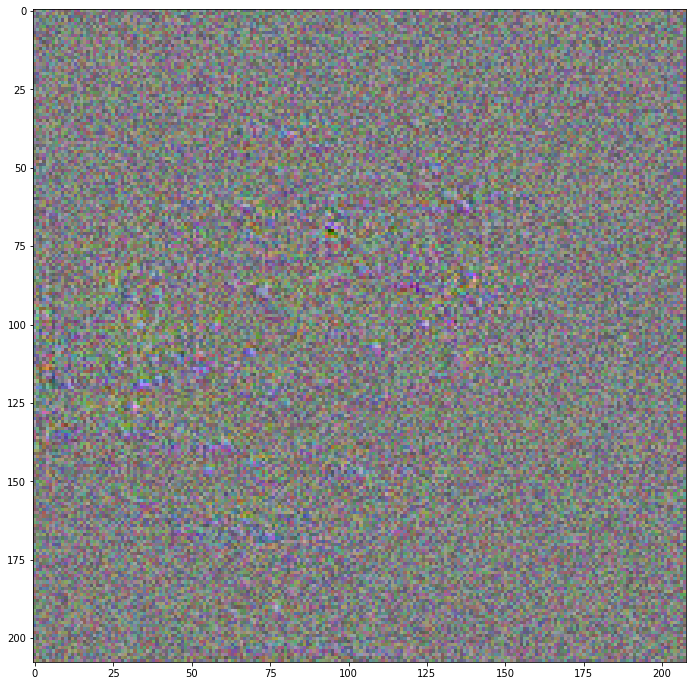

In [123]:
random_input_image = np.random.random((1, IMG_ROWS, IMG_COLS, IMG_CHANNELS)) * 20 + 128.
output_image = model.get_layer('conv_out').output
input_image = model.get_layer('input_layer').input
target_class = active_labels.index(class_map['Cancer'])

loss = (K.mean(output_image[...,target_class], axis=-1)
       -K.mean(
           K.concatenate((
               output_image[...,:target_class],
               output_image[...,target_class+1:]
               )), axis=-1)
       )
step = 1.
grads = K.gradients(loss, input_image)[0] 
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)
grads = normalize(grads)
iterate = K.function([input_image], [loss, grads])
for i in range(30):
    loss_value, grads_value = iterate([random_input_image])
    random_input_image += grads_value * step
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
result_img = deprocess_image(random_input_image[0])
plt.rcParams["figure.figsize"] = (12.0, 12.0)
plt.imshow(result_img)

In [141]:
train_slides = load_slides_as_dict(data_path,'train', load_gt=False)
print(len(train_slides))


Text(0.5, 1.0, 'TPEF')

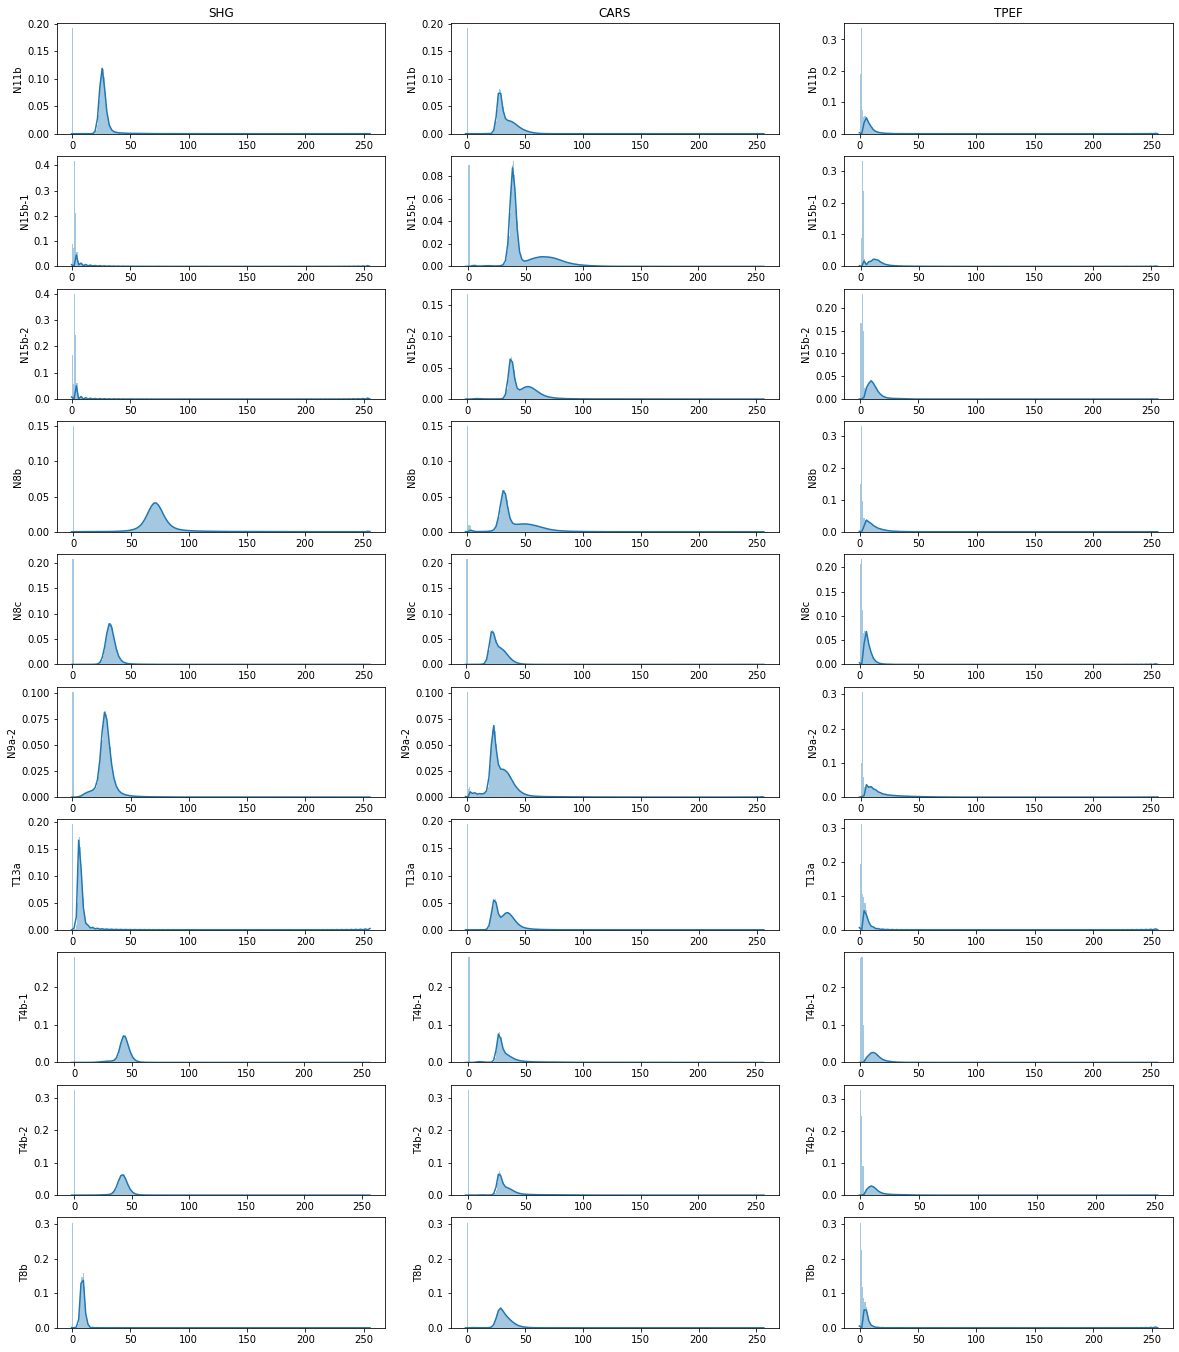

In [152]:
from itertools import product
import seaborn as sns
num_slides = len(train_slides)
plt.rcParams["figure.figsize"] = (20.0, 24.0)
fig, axes = plt.subplots(nrows=num_slides, ncols=3)
for (row, (name, img)), col in product(enumerate(train_slides.items()), range(3)):
    axes[row][col].set_ylabel(name)
    sns.distplot(a = np.ravel(img[...,col])*255, bins=256, hist=True, ax=axes[row][col])
axes[0][0].set_title("SHG")
axes[0][1].set_title("CARS")
axes[0][2].set_title("TPEF")